# Chapter 21 - The NBEATS Model

## Listing 21-1. Import the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('hierarchical_sales_data.csv')

df_sum = df[['DATE']]

# Sum the sales and promos of the different products
df_sum['SALES'] = df[[x for x in df.columns if x.startswith('QTY')]].sum(axis=1)
df_sum['PROMO'] = df[[x for x in df.columns if x.startswith('PROMO')]].sum(axis=1)

# Create sum of sales and promos per month
df_sum['YEAR_MONTH'] = df_sum['DATE'].apply(lambda x: x[:7])
df_sum = df_sum[['SALES', 'PROMO', 'YEAR_MONTH']].groupby('YEAR_MONTH').sum()
df_sum.head()

# Preview the data
df_sum.head()


/var/folders/5z/nxlf2r4n5yx6qy1wbzvkr3xr0000gn/T/ipykernel_66028/896776394.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum['SALES'] = df[[x for x in df.columns if x.startswith('QTY')]].sum(axis=1)
/var/folders/5z/nxlf2r4n5yx6qy1wbzvkr3xr0000gn/T/ipykernel_66028/896776394.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum['PROMO'] = df[[x for x in df.columns if x.startswith('PROMO')]].sum(axis=1)
/var/folders/5z/nxlf2r4n5yx6qy1wbzvkr3xr0000gn/T/ipykernel_66028/896776394.py:14: SettingWit

,SALES,PROMO
YEAR_MONTH,,
2014-01,12819,990
2014-02,17906,1329
2014-03,12047,896
2014-04,15998,1235
2014-05,17453,1354


## Listing 21-2. Remember the impact of promos on sales

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '2018-03'),
  Text(0.0, 0, '2014-01'),
  Text(10.0, 0, '2014-11'),
  Text(20.0, 0, '2015-09'),
  Text(30.0, 0, '2016-07'),
  Text(40.0, 0, '2017-05'),
  Text(50.0, 0, '2018-03'),
  Text(60.0, 0, ''),
  Text(70.0, 0, '')])

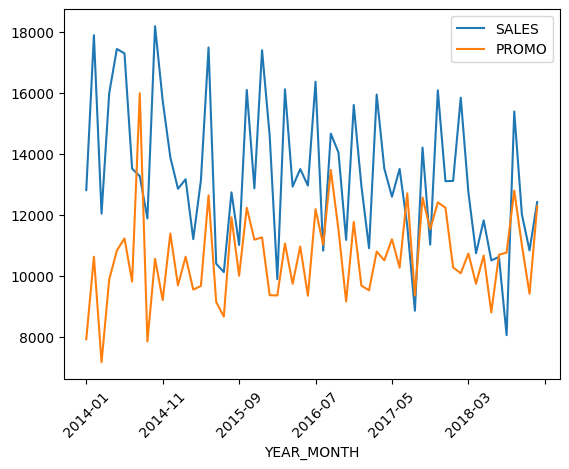

In [2]:
df_scaled = df_sum[['SALES']]
df_scaled['PROMO'] = df_sum['PROMO'] * 8

df_scaled.plot()
plt.xticks(rotation=45)

## Listing 21-3. Prepare for Darts and create univariate train test split

In [3]:
import numpy as np
from darts.timeseries import TimeSeries

# Convert sales data to float32 for Darts
df_sum['SALES'] = df_sum['SALES'].map(np.float32)

# Convert the dataframe index to a datetime index as required by Darts
df_sum.index = pd.DatetimeIndex(df_sum.index)

# Full year 2014 to 2017 is the training data
train = df_sum.iloc[:-12]

# Full year 2018 is the test data
test = df_sum.iloc[-12:]

# Convert the training data to a Darts time series
train_series = TimeSeries.from_dataframe(train[['SALES']])

# Inspect the time series format
train_series

<TimeSeries (DataArray) (YEAR_MONTH: 48, component: 1, sample: 1)> Size: 192B
array([[[12819.]],

       [[17906.]],

       [[12047.]],

       [[15998.]],

       [[17453.]],

       [[17310.]],

       [[13523.]],

       [[13279.]],

       [[11887.]],

       [[18202.]],

...

       [[15957.]],

       [[13524.]],

       [[12601.]],

       [[13516.]],

       [[11642.]],

       [[ 8858.]],

       [[14215.]],

       [[11029.]],

       [[16095.]],

       [[13111.]]], dtype=float32)
Coordinates:
  * YEAR_MONTH  (YEAR_MONTH) datetime64[ns] 384B 2014-01-01 ... 2017-12-01
  * component   (component) <U5 20B 'SALES'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

## Listing 21-4. Create default model

In [4]:
# Use MLFlow autologging for Darts
import mlflow
mlflow.autolog()

# import the NBEATSModel
from darts.models.forecasting.nbeats import NBEATSModel

# Specifying a default model
model = NBEATSModel(
    # with input chunck length 24 (number of time steps that each NBEATS block uses as input)
    input_chunk_length=24,
    # with output chunck 12 (number of time steps that each NBEATS block uses as output)
    output_chunk_length=12,
    # 5 epochs to have a quick first result
    n_epochs=5,
    random_state=123
)

# Train the model
model.fit(train_series)

2025/06/12 10:24:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/12 10:24:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/06/12 10:24:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/06/12 10:24:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:24:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f34468b29ef94e7c98ff5bd66b5f14fe', which will track hyperparameters, performance metrics, model artifacts, and lineage information 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s, train_loss=1.81e+8]

2025/06/12 10:24:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s, train_loss=4.7e+7] 

2025/06/12 10:24:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s, train_loss=2.11e+7]

2025/06/12 10:24:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s, train_loss=2.01e+7]

2025/06/12 10:24:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, train_loss=9.07e+6]

2025/06/12 10:24:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s, train_loss=9.07e+6]


2025/06/12 10:24:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=5, random_state=123)

## Listing 21-5. Build the forecast and analyze results

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]
0.8128965348005295


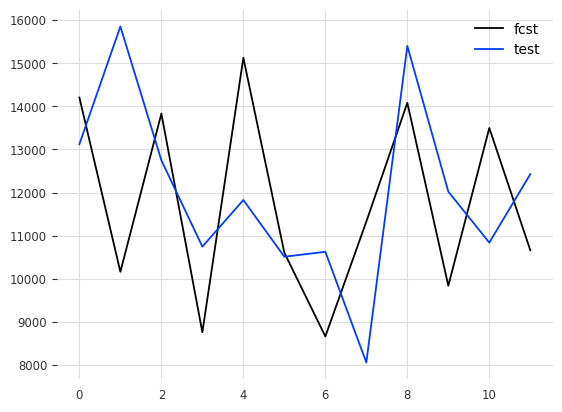

In [5]:
from sklearn.metrics import mean_absolute_percentage_error

# Forecast 12 steps using this model
fcst = model.predict(12).values()

# Compute metric
metric = 1 - mean_absolute_percentage_error(list(test['SALES']), fcst)
print(metric)

plt.plot(fcst)
plt.plot(list(test['SALES']))
plt.legend(['fcst', 'test'])

## Listing 21-6. Create multivariate train test split (future promos not possible)

In [6]:
df_sum['PROMO'] = df_sum['PROMO'].map(np.float32)

# Convert the training data to a Darts time series
promos_train = TimeSeries.from_dataframe(train[['PROMO']])

# Convert to float32 for Darts
promos_train = promos_train.astype(np.float32)

## Listing 21-7 Create multivariate model

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:24:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '94f95f1196fd48439dda06dcf3d47dc7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
1.6 K     Non-trainable params
6.4 M     Total params
25.551    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=1.72e+8]

2025/06/12 10:24:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss=6.64e+7]

2025/06/12 10:24:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s, train_loss=9.85e+6]

2025/06/12 10:24:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s, train_loss=4.99e+7]

2025/06/12 10:24:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, train_loss=1.77e+7]

2025/06/12 10:24:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=1.77e+7]


2025/06/12 10:24:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.23it/s]
0.8212695717811584


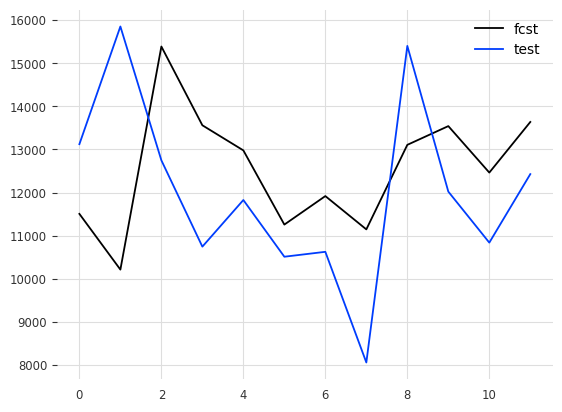

In [7]:
# Specifying a default model
model = NBEATSModel(
    # with input chunck length 24 (number of time steps that each NBEATS block uses as input)
    input_chunk_length=24,
    # with output chunck 12 (number of time steps that each NBEATS block uses as output)
    output_chunk_length=12,
    # 5 epochs to have a quick first result
    n_epochs=5,
    random_state=123

    
)

# Train the model
model.fit(
    train_series,
    
    # add the promotions as past covariates
    past_covariates=promos_train
)


# Forecast 12 steps using this model
fcst = model.predict(
    n=12,

    # add past covariates (promos train)
    past_covariates=promos_train,
    
).values()

# Compute metric
metric = 1 - mean_absolute_percentage_error(list(test['SALES']), fcst)
print(metric)

plt.plot(fcst)
plt.plot(list(test['SALES']))
plt.legend(['fcst', 'test'])

## Listing 21-8. Tune multivariate model hyperparameters and analyze

In [8]:
def score_nbeats(input_chunck_length, n_epochs, num_stacks, expansion_coefficient_dim):
    
    # Specifying a model using the gridsearch parameters
    model = NBEATSModel(
        input_chunk_length=input_chunck_length,
        output_chunk_length=12,
        n_epochs=n_epochs,
        num_stacks=num_stacks,
        expansion_coefficient_dim=expansion_coefficient_dim,
        random_state=123
    )
    
    # Train the model
    model.fit(
        train_series,
        
        # add the promotions as past covariates
        past_covariates=promos_train
    )
    
    
    # Forecast 12 steps using this model
    fcst = model.predict(
        n=12,
    
        # add past covariates (promos train)
        past_covariates=promos_train,
        
    ).values()
    
    # Compute metric
    metric = 1 - mean_absolute_percentage_error(list(test['SALES']), fcst)

    return metric

# Run a Grid Search
grid_result = []
for input_chunck_length in [6, 12, 18, 24]:
    for n_epochs in [5, 10, 20]:
        for num_stacks in [15, 30, 45]:
            for expansion_coefficient_dim in [3, 5, 7]:
                r2_test = score_nbeats(input_chunck_length, n_epochs, num_stacks, expansion_coefficient_dim)
                result = [input_chunck_length, n_epochs, num_stacks, expansion_coefficient_dim, r2_test]
                grid_result.append(result)


# Inspect the results in a DataFrame
grid_output = pd.DataFrame(grid_result, columns=[
    'input_chunck_length', 
    'n_epochs', 
    'num_stacks', 
    'expansion_coefficient_dim', 
    'r2_test'
])

grid_output.sort_values('r2_test', ascending=False).head()
                                 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:24:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f0f352e8b67041658470e38a1d184820', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.0 M  | train
-------------------------------------------------------------
3.0 M     Trainable params
819       Non-trainable params
3.0 M     Total params
12.143    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=1.85e+8]

2025/06/12 10:24:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s, train_loss=1.24e+8]

2025/06/12 10:24:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s, train_loss=7.45e+7]

2025/06/12 10:24:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s, train_loss=3.54e+7]

2025/06/12 10:24:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s, train_loss=3.12e+7]

2025/06/12 10:24:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s, train_loss=3.12e+7]


2025/06/12 10:24:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.07it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:24:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e6913a7d6adb4abead14783bb8ce5ddf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.4 K     Non-trainable params
3.1 M     Total params
12.209    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s, train_loss=1.81e+8]

2025/06/12 10:24:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s, train_loss=1.19e+8]

2025/06/12 10:24:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s, train_loss=6.69e+7]

2025/06/12 10:24:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s, train_loss=2.32e+7]

2025/06/12 10:24:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s, train_loss=2.1e+7] 

2025/06/12 10:24:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s, train_loss=2.1e+7]


2025/06/12 10:24:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.74it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:24:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e50f11c439f94b7ca33729e0171621a5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.9 K     Non-trainable params
3.1 M     Total params
12.275    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, train_loss=1.88e+8]

2025/06/12 10:24:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s, train_loss=1.3e+8] 

2025/06/12 10:24:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s, train_loss=8.09e+7]

2025/06/12 10:24:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s, train_loss=3.65e+7]

2025/06/12 10:24:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s, train_loss=2.81e+7]

2025/06/12 10:24:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s, train_loss=2.81e+7]


2025/06/12 10:24:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.41it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:24:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e27daa7c8013415c983fc8718121338f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
819       Non-trainable params
6.1 M     Total params
24.287    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s, train_loss=1.83e+8]

2025/06/12 10:24:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s, train_loss=8.21e+7]

2025/06/12 10:24:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, train_loss=2.92e+7]

2025/06/12 10:24:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s, train_loss=2.92e+7]

2025/06/12 10:24:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss=1.42e+7]

2025/06/12 10:24:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s, train_loss=1.42e+7]


2025/06/12 10:24:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:24:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1925ff087cbd4852a0d63f4e56423e50', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.419    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s, train_loss=1.85e+8]

2025/06/12 10:24:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s, train_loss=7.92e+7]

2025/06/12 10:24:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s, train_loss=1.75e+7]

2025/06/12 10:24:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s, train_loss=3.28e+7]

2025/06/12 10:24:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s, train_loss=2.46e+7]

2025/06/12 10:24:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s, train_loss=2.46e+7]


2025/06/12 10:24:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.65it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:24:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7c66d04914544c379b1dea2475561d4c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.9 K     Non-trainable params
6.1 M     Total params
24.551    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s, train_loss=1.85e+8]

2025/06/12 10:24:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, train_loss=8.08e+7]

2025/06/12 10:24:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s, train_loss=1.99e+7]

2025/06/12 10:24:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s, train_loss=4.66e+7]

2025/06/12 10:24:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, train_loss=1.49e+7]

2025/06/12 10:24:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s, train_loss=1.49e+7]


2025/06/12 10:25:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.86it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:25:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7caea44d4ecf47129da38edf01c1cf2f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.1 M  | train
-------------------------------------------------------------
9.1 M     Trainable params
819       Non-trainable params
9.1 M     Total params
36.430    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, train_loss=1.8e+8]

2025/06/12 10:25:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=4.82e+7]

2025/06/12 10:25:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s, train_loss=2.6e+7] 

2025/06/12 10:25:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s, train_loss=1.55e+7]

2025/06/12 10:25:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=1.05e+7]

2025/06/12 10:25:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=1.05e+7]


2025/06/12 10:25:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025/06/12 10:25:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '635a5040c1d7458f8df0e3aa2192550c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
1.4 K     Non-trainable params
9.2 M     Total params
36.628    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s, train_loss=1.81e+8]

2025/06/12 10:25:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, train_loss=4.19e+7]

2025/06/12 10:25:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, train_loss=1.89e+7]

2025/06/12 10:25:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, train_loss=2.21e+7]

2025/06/12 10:25:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=9.16e+6]

2025/06/12 10:25:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, train_loss=9.16e+6]


2025/06/12 10:25:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.77it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:25:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e66fcd3b500c40c5b3b39dd8c3b08ae4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
1.9 K     Non-trainable params
9.2 M     Total params
36.826    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s, train_loss=1.83e+8]

2025/06/12 10:25:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, train_loss=4.22e+7]

2025/06/12 10:25:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=3.24e+7]

2025/06/12 10:25:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, train_loss=1.13e+7]

2025/06/12 10:25:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=9.12e+6]

2025/06/12 10:25:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=9.12e+6]


2025/06/12 10:25:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.62it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025/06/12 10:25:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3cf8104c18c248de85ec25abdc14166b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.0 M  | train
-------------------------------------------------------------
3.0 M     Trainable params
819       Non-trainable params
3.0 M     Total params
12.143    Total estimated model params size (MB)
201       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s, train_loss=1.85e+8]

2025/06/12 10:25:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s, train_loss=1.24e+8]

2025/06/12 10:25:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s, train_loss=7.45e+7]

2025/06/12 10:25:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s, train_loss=3.54e+7]

2025/06/12 10:25:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s, train_loss=3.12e+7]

2025/06/12 10:25:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s, train_loss=2.83e+7]

2025/06/12 10:25:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s, train_loss=1.58e+7]

2025/06/12 10:25:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s, train_loss=1.13e+7]

2025/06/12 10:25:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s, train_loss=1.14e+7]

2025/06/12 10:25:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s, train_loss=1.18e+7]

2025/06/12 10:25:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s, train_loss=1.18e+7]


2025/06/12 10:25:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.81it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:25:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cee7bf10e5224843a38e823742f99ff7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.4 K     Non-trainable params
3.1 M     Total params
12.209    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s, train_loss=1.81e+8]

2025/06/12 10:25:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s, train_loss=1.19e+8]

2025/06/12 10:25:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s, train_loss=6.69e+7]

2025/06/12 10:25:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s, train_loss=2.32e+7]

2025/06/12 10:25:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s, train_loss=2.1e+7] 

2025/06/12 10:25:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s, train_loss=3.08e+7]

2025/06/12 10:25:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s, train_loss=1.95e+7]

2025/06/12 10:25:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s, train_loss=1.18e+7]

2025/06/12 10:25:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s, train_loss=1.14e+7]

2025/06/12 10:25:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s, train_loss=1.33e+7]

2025/06/12 10:25:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, train_loss=1.33e+7]


2025/06/12 10:25:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.29it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:25:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bf78b95471fd46159771a683efc3cf18', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.9 K     Non-trainable params
3.1 M     Total params
12.275    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s, train_loss=1.88e+8]

2025/06/12 10:25:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s, train_loss=1.3e+8] 

2025/06/12 10:25:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s, train_loss=8.09e+7]

2025/06/12 10:25:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s, train_loss=3.65e+7]

2025/06/12 10:25:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s, train_loss=2.81e+7]

2025/06/12 10:25:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s, train_loss=2.32e+7]

2025/06/12 10:25:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s, train_loss=1.32e+7]

2025/06/12 10:25:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s, train_loss=1.25e+7]

2025/06/12 10:25:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s, train_loss=1.55e+7]

2025/06/12 10:25:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s, train_loss=1.69e+7]

2025/06/12 10:25:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s, train_loss=1.69e+7]


2025/06/12 10:25:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.97it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:25:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '09f3749bad1b4332a4bc40a18782b0ab', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
819       Non-trainable params
6.1 M     Total params
24.287    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, train_loss=1.83e+8]

2025/06/12 10:25:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss=8.21e+7]

2025/06/12 10:25:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, train_loss=2.92e+7]

2025/06/12 10:25:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s, train_loss=2.92e+7]

2025/06/12 10:25:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, train_loss=1.42e+7]

2025/06/12 10:25:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s, train_loss=1.37e+7]

2025/06/12 10:25:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s, train_loss=1.42e+7]

2025/06/12 10:25:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss=1.22e+7]

2025/06/12 10:25:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, train_loss=9.94e+6]

2025/06/12 10:25:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, train_loss=8.84e+6]

2025/06/12 10:25:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss=8.84e+6]


2025/06/12 10:25:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.55it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:25:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '294753415f27473ebd3730f3c56a3ca0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.419    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s, train_loss=1.85e+8]

2025/06/12 10:25:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=7.92e+7]

2025/06/12 10:25:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s, train_loss=1.75e+7]

2025/06/12 10:25:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s, train_loss=3.28e+7]

2025/06/12 10:25:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss=2.46e+7]

2025/06/12 10:25:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s, train_loss=9.43e+6]

2025/06/12 10:25:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, train_loss=8.96e+6]

2025/06/12 10:25:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s, train_loss=1.24e+7]

2025/06/12 10:25:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s, train_loss=1.33e+7]

2025/06/12 10:25:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s, train_loss=1.13e+7]

2025/06/12 10:25:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s, train_loss=1.13e+7]


2025/06/12 10:25:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.19it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:25:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '71334d28108b4837ad2fc257022bbf50', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.9 K     Non-trainable params
6.1 M     Total params
24.551    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s, train_loss=1.85e+8]

2025/06/12 10:25:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s, train_loss=8.08e+7]

2025/06/12 10:25:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s, train_loss=1.99e+7]

2025/06/12 10:25:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, train_loss=4.66e+7]

2025/06/12 10:25:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s, train_loss=1.49e+7]

2025/06/12 10:25:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=9.12e+6]

2025/06/12 10:25:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss=1.5e+7] 

2025/06/12 10:25:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss=1.74e+7]

2025/06/12 10:25:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.69it/s, train_loss=1.5e+7] 

2025/06/12 10:25:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s, train_loss=1.04e+7]

2025/06/12 10:25:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s, train_loss=1.04e+7]


2025/06/12 10:25:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.96it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:25:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '09d3f9e1ce7645d9bad1d160cb335dfb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.1 M  | train
-------------------------------------------------------------
9.1 M     Trainable params
819       Non-trainable params
9.1 M     Total params
36.430    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s, train_loss=1.8e+8]

2025/06/12 10:25:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=4.82e+7]

2025/06/12 10:25:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=2.6e+7] 

2025/06/12 10:25:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=1.55e+7]

2025/06/12 10:25:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s, train_loss=1.05e+7]

2025/06/12 10:25:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, train_loss=1.15e+7]

2025/06/12 10:25:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=1.07e+7]

2025/06/12 10:25:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s, train_loss=8.48e+6]

2025/06/12 10:25:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, train_loss=6.95e+6]

2025/06/12 10:25:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, train_loss=7.11e+6]

2025/06/12 10:25:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=7.11e+6]


2025/06/12 10:25:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.79it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:25:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bbbcec88f2fb4a48ba417ce3fc11c0ed', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
1.4 K     Non-trainable params
9.2 M     Total params
36.628    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=1.81e+8]

2025/06/12 10:26:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, train_loss=4.19e+7]

2025/06/12 10:26:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=1.89e+7]

2025/06/12 10:26:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, train_loss=2.21e+7]

2025/06/12 10:26:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, train_loss=9.16e+6]

2025/06/12 10:26:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, train_loss=9.3e+6] 

2025/06/12 10:26:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=1.1e+7]

2025/06/12 10:26:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s, train_loss=9.7e+6]

2025/06/12 10:26:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, train_loss=7.65e+6]

2025/06/12 10:26:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=7.22e+6]

2025/06/12 10:26:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=7.22e+6]


2025/06/12 10:26:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.59it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:26:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bb70baa379f14367a07ee33eb5c05b8e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
1.9 K     Non-trainable params
9.2 M     Total params
36.826    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s, train_loss=1.83e+8]

2025/06/12 10:26:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, train_loss=4.22e+7]

2025/06/12 10:26:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=3.24e+7]

2025/06/12 10:26:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=1.13e+7]

2025/06/12 10:26:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=9.12e+6]

2025/06/12 10:26:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, train_loss=1.28e+7]

2025/06/12 10:26:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=1.14e+7]

2025/06/12 10:26:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, train_loss=7.76e+6]

2025/06/12 10:26:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=6.37e+6]

2025/06/12 10:26:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, train_loss=7.8e+6] 

2025/06/12 10:26:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=7.8e+6]


2025/06/12 10:26:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.60it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025/06/12 10:26:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3f0edea67c274d5581df99381930bd15', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.0 M  | train
-------------------------------------------------------------
3.0 M     Trainable params
819       Non-trainable params
3.0 M     Total params
12.143    Total estimated model params size (MB)
201       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s, train_loss=1.85e+8]

2025/06/12 10:26:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s, train_loss=1.24e+8]

2025/06/12 10:26:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s, train_loss=7.45e+7]

2025/06/12 10:26:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s, train_loss=3.54e+7]

2025/06/12 10:26:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, train_loss=3.12e+7]

2025/06/12 10:26:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, train_loss=2.83e+7]

2025/06/12 10:26:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s, train_loss=1.58e+7]

2025/06/12 10:26:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, train_loss=1.13e+7]

2025/06/12 10:26:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s, train_loss=1.14e+7]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s, train_loss=1.18e+7]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s, train_loss=1.14e+7]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s, train_loss=1.06e+7]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s, train_loss=9.88e+6]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s, train_loss=9.17e+6]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s, train_loss=8.28e+6]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s, train_loss=7.79e+6]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s, train_loss=7.8e+6] 

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s, train_loss=7.81e+6]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s, train_loss=7.55e+6]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s, train_loss=7.12e+6]

2025/06/12 10:26:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s, train_loss=7.12e+6]


2025/06/12 10:26:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.69it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:26:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e30744c005224ff6a0d38e401ca0a723', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.4 K     Non-trainable params
3.1 M     Total params
12.209    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s, train_loss=1.81e+8]

2025/06/12 10:26:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s, train_loss=1.19e+8]

2025/06/12 10:26:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s, train_loss=6.69e+7]

2025/06/12 10:26:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s, train_loss=2.32e+7]

2025/06/12 10:26:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s, train_loss=2.1e+7] 

2025/06/12 10:26:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s, train_loss=3.08e+7]

2025/06/12 10:26:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s, train_loss=1.95e+7]

2025/06/12 10:26:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, train_loss=1.18e+7]

2025/06/12 10:26:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s, train_loss=1.14e+7]

2025/06/12 10:26:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s, train_loss=1.33e+7]

2025/06/12 10:26:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s, train_loss=1.41e+7]

2025/06/12 10:26:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s, train_loss=1.3e+7] 

2025/06/12 10:26:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s, train_loss=1.1e+7]

2025/06/12 10:26:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s, train_loss=9.36e+6]

2025/06/12 10:26:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s, train_loss=8.77e+6]

2025/06/12 10:26:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s, train_loss=8.69e+6]

2025/06/12 10:26:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s, train_loss=8.3e+6] 

2025/06/12 10:26:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s, train_loss=7.67e+6]

2025/06/12 10:26:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s, train_loss=7.3e+6] 

2025/06/12 10:26:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s, train_loss=7.34e+6]

2025/06/12 10:26:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s, train_loss=7.34e+6]


2025/06/12 10:26:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.42it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:26:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '03f17d33e9554e60bf9b9bfa91448e37', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.9 K     Non-trainable params
3.1 M     Total params
12.275    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s, train_loss=1.88e+8]

2025/06/12 10:26:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s, train_loss=1.3e+8] 

2025/06/12 10:26:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s, train_loss=8.09e+7]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s, train_loss=3.65e+7]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s, train_loss=2.81e+7]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s, train_loss=2.32e+7]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s, train_loss=1.32e+7]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s, train_loss=1.25e+7]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s, train_loss=1.55e+7]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s, train_loss=1.69e+7]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s, train_loss=1.57e+7]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, train_loss=1.27e+7]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s, train_loss=9.22e+6]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, train_loss=7.09e+6]

2025/06/12 10:26:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s, train_loss=7.29e+6]

2025/06/12 10:26:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s, train_loss=8.64e+6]

2025/06/12 10:26:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s, train_loss=9.02e+6]

2025/06/12 10:26:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s, train_loss=8.21e+6]

2025/06/12 10:26:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s, train_loss=7.27e+6]

2025/06/12 10:26:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s, train_loss=6.83e+6]

2025/06/12 10:26:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s, train_loss=6.83e+6]


2025/06/12 10:26:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.56it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:26:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '604ae77c159e48a3ae6388d7de83da4d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
819       Non-trainable params
6.1 M     Total params
24.287    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s, train_loss=1.83e+8]

2025/06/12 10:26:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s, train_loss=8.21e+7]

2025/06/12 10:26:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, train_loss=2.92e+7]

2025/06/12 10:26:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s, train_loss=2.92e+7]

2025/06/12 10:26:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, train_loss=1.42e+7]

2025/06/12 10:26:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss=1.37e+7]

2025/06/12 10:26:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s, train_loss=1.42e+7]

2025/06/12 10:26:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s, train_loss=1.22e+7]

2025/06/12 10:26:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s, train_loss=9.94e+6]

2025/06/12 10:26:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s, train_loss=8.84e+6]

2025/06/12 10:26:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s, train_loss=8.46e+6]

2025/06/12 10:26:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, train_loss=7.89e+6]

2025/06/12 10:26:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s, train_loss=7.44e+6]

2025/06/12 10:26:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s, train_loss=7.51e+6]

2025/06/12 10:26:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, train_loss=7.55e+6]

2025/06/12 10:26:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss=7.13e+6]

2025/06/12 10:26:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s, train_loss=6.5e+6] 

2025/06/12 10:26:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=6.18e+6]

2025/06/12 10:26:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss=6.21e+6]

2025/06/12 10:26:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=6.19e+6]

2025/06/12 10:26:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s, train_loss=6.19e+6]


2025/06/12 10:26:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.03it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:26:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '57c3d39a19e747eeb4729f1a8fb85ac0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.419    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s, train_loss=1.85e+8]

2025/06/12 10:26:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s, train_loss=7.92e+7]

2025/06/12 10:26:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s, train_loss=1.75e+7]

2025/06/12 10:26:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s, train_loss=3.28e+7]

2025/06/12 10:26:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, train_loss=2.46e+7]

2025/06/12 10:26:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s, train_loss=9.43e+6]

2025/06/12 10:26:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s, train_loss=8.96e+6]

2025/06/12 10:26:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=1.24e+7]

2025/06/12 10:26:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s, train_loss=1.33e+7]

2025/06/12 10:26:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s, train_loss=1.13e+7]

2025/06/12 10:26:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss=8.4e+6] 

2025/06/12 10:26:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, train_loss=6.88e+6]

2025/06/12 10:26:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, train_loss=7.72e+6]

2025/06/12 10:26:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s, train_loss=8.69e+6]

2025/06/12 10:26:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, train_loss=7.99e+6]

2025/06/12 10:26:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=6.74e+6]

2025/06/12 10:26:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s, train_loss=6.2e+6] 

2025/06/12 10:26:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss=6.39e+6]

2025/06/12 10:26:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s, train_loss=6.72e+6]

2025/06/12 10:26:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s, train_loss=6.75e+6]

2025/06/12 10:26:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s, train_loss=6.75e+6]


2025/06/12 10:26:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.36it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:26:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9c58b21178bd42eb9fb4851ad0d41482', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.9 K     Non-trainable params
6.1 M     Total params
24.551    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s, train_loss=1.85e+8]

2025/06/12 10:26:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss=8.08e+7]

2025/06/12 10:26:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s, train_loss=1.99e+7]

2025/06/12 10:26:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, train_loss=4.66e+7]

2025/06/12 10:26:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s, train_loss=1.49e+7]

2025/06/12 10:26:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s, train_loss=9.12e+6]

2025/06/12 10:26:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s, train_loss=1.5e+7] 

2025/06/12 10:26:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s, train_loss=1.74e+7]

2025/06/12 10:26:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s, train_loss=1.5e+7] 

2025/06/12 10:26:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=1.04e+7]

2025/06/12 10:26:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=6.94e+6]

2025/06/12 10:26:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=7.05e+6]

2025/06/12 10:26:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s, train_loss=9.2e+6] 

2025/06/12 10:26:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, train_loss=9.39e+6]

2025/06/12 10:26:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, train_loss=7.78e+6]

2025/06/12 10:26:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, train_loss=6.53e+6]

2025/06/12 10:26:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=6.4e+6] 

2025/06/12 10:26:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, train_loss=6.78e+6]

2025/06/12 10:26:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s, train_loss=6.94e+6]

2025/06/12 10:26:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss=6.7e+6] 

2025/06/12 10:26:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s, train_loss=6.7e+6]


2025/06/12 10:26:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.68it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:26:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8ad279d1600b444abb6dde87866af66d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.1 M  | train
-------------------------------------------------------------
9.1 M     Trainable params
819       Non-trainable params
9.1 M     Total params
36.430    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, train_loss=1.8e+8]

2025/06/12 10:26:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=4.82e+7]

2025/06/12 10:26:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s, train_loss=2.6e+7] 

2025/06/12 10:26:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, train_loss=1.55e+7]

2025/06/12 10:26:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, train_loss=1.05e+7]

2025/06/12 10:26:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s, train_loss=1.15e+7]

2025/06/12 10:26:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s, train_loss=1.07e+7]

2025/06/12 10:26:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=8.48e+6]

2025/06/12 10:26:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, train_loss=6.95e+6]

2025/06/12 10:26:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, train_loss=7.11e+6]

2025/06/12 10:26:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=7.46e+6]

2025/06/12 10:26:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, train_loss=7.11e+6]

2025/06/12 10:26:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=6.57e+6]

2025/06/12 10:26:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=6.2e+6] 

2025/06/12 10:26:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s, train_loss=5.92e+6]

2025/06/12 10:26:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, train_loss=5.69e+6]

2025/06/12 10:26:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s, train_loss=5.61e+6]

2025/06/12 10:26:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, train_loss=5.7e+6] 

2025/06/12 10:26:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, train_loss=5.75e+6]

2025/06/12 10:26:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s, train_loss=5.5e+6] 

2025/06/12 10:26:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s, train_loss=5.5e+6]


2025/06/12 10:27:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.00it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:27:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bd35f34285924a67ad11d87bdcad9611', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
1.4 K     Non-trainable params
9.2 M     Total params
36.628    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s, train_loss=1.81e+8]

2025/06/12 10:27:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=4.19e+7]

2025/06/12 10:27:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s, train_loss=1.89e+7]

2025/06/12 10:27:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, train_loss=2.21e+7]

2025/06/12 10:27:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=9.16e+6]

2025/06/12 10:27:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s, train_loss=9.3e+6] 

2025/06/12 10:27:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, train_loss=1.1e+7]

2025/06/12 10:27:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, train_loss=9.7e+6]

2025/06/12 10:27:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, train_loss=7.65e+6]

2025/06/12 10:27:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s, train_loss=7.22e+6]

2025/06/12 10:27:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s, train_loss=7.61e+6]

2025/06/12 10:27:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, train_loss=7.12e+6]

2025/06/12 10:27:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, train_loss=6.44e+6]

2025/06/12 10:27:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, train_loss=6.29e+6]

2025/06/12 10:27:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, train_loss=6.38e+6]

2025/06/12 10:27:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s, train_loss=6.27e+6]

2025/06/12 10:27:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, train_loss=5.96e+6]

2025/06/12 10:27:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=5.68e+6]

2025/06/12 10:27:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, train_loss=5.59e+6]

2025/06/12 10:27:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s, train_loss=5.59e+6]

2025/06/12 10:27:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s, train_loss=5.59e+6]


2025/06/12 10:27:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:27:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bd9192c516a646b9815db56a9de2d2df', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
1.9 K     Non-trainable params
9.2 M     Total params
36.826    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s, train_loss=1.83e+8]

2025/06/12 10:27:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, train_loss=4.22e+7]

2025/06/12 10:27:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s, train_loss=3.24e+7]

2025/06/12 10:27:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=1.13e+7]

2025/06/12 10:27:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=9.12e+6]

2025/06/12 10:27:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=1.28e+7]

2025/06/12 10:27:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=1.14e+7]

2025/06/12 10:27:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, train_loss=7.76e+6]

2025/06/12 10:27:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s, train_loss=6.37e+6]

2025/06/12 10:27:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=7.8e+6] 

2025/06/12 10:27:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s, train_loss=7.94e+6]

2025/06/12 10:27:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s, train_loss=6.83e+6]

2025/06/12 10:27:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, train_loss=6.23e+6]

2025/06/12 10:27:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s, train_loss=6.23e+6]

2025/06/12 10:27:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=6.26e+6]

2025/06/12 10:27:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, train_loss=6.07e+6]

2025/06/12 10:27:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, train_loss=5.8e+6] 

2025/06/12 10:27:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=5.63e+6]

2025/06/12 10:27:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=5.62e+6]

2025/06/12 10:27:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s, train_loss=5.59e+6]

2025/06/12 10:27:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s, train_loss=5.59e+6]


2025/06/12 10:27:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.43it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025/06/12 10:27:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1abcb664d06641e49146f9b8b7027fe2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
867       Non-trainable params
3.1 M     Total params
12.331    Total estimated model params size (MB)
201       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s, train_loss=1.84e+8]

2025/06/12 10:27:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s, train_loss=1.22e+8]

2025/06/12 10:27:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s, train_loss=6.81e+7]

2025/06/12 10:27:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s, train_loss=2.92e+7]

2025/06/12 10:27:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s, train_loss=3.75e+7]

2025/06/12 10:27:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s, train_loss=3.75e+7]


2025/06/12 10:27:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.68it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:27:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c470213014b34752a0f7ce72a4c6942c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.4 K     Non-trainable params
3.1 M     Total params
12.398    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s, train_loss=1.84e+8]

2025/06/12 10:27:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s, train_loss=1.24e+8]

2025/06/12 10:27:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s, train_loss=7.15e+7]

2025/06/12 10:27:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s, train_loss=2.82e+7]

2025/06/12 10:27:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s, train_loss=3.06e+7]

2025/06/12 10:27:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s, train_loss=3.06e+7]


2025/06/12 10:27:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.16it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:27:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f0ffa0ec63004d34acf586b7624fe74e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
2.0 K     Non-trainable params
3.1 M     Total params
12.465    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s, train_loss=1.85e+8]

2025/06/12 10:27:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s, train_loss=1.19e+8]

2025/06/12 10:27:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s, train_loss=6.3e+7] 

2025/06/12 10:27:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s, train_loss=2.14e+7]

2025/06/12 10:27:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s, train_loss=4.07e+7]

2025/06/12 10:27:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s, train_loss=4.07e+7]


2025/06/12 10:27:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.87it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:27:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f599ba6ea027470387bb06c1834d01d9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
867       Non-trainable params
6.2 M     Total params
24.661    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss=1.81e+8]

2025/06/12 10:27:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s, train_loss=7.62e+7]

2025/06/12 10:27:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=2.14e+7]

2025/06/12 10:27:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s, train_loss=3.75e+7]

2025/06/12 10:27:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s, train_loss=1.91e+7]

2025/06/12 10:27:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s, train_loss=1.91e+7]


2025/06/12 10:27:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.20it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:27:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9026ba173b8e48dca4f44f923567c62d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.796    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s, train_loss=1.84e+8]

2025/06/12 10:27:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=7.58e+7]

2025/06/12 10:27:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=1.83e+7]

2025/06/12 10:27:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, train_loss=3.64e+7]

2025/06/12 10:27:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s, train_loss=1.96e+7]

2025/06/12 10:27:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s, train_loss=1.96e+7]


2025/06/12 10:27:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.39it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:27:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd805f80f96ae4e17b1a67bce2cfd1ab4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
2.0 K     Non-trainable params
6.2 M     Total params
24.931    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s, train_loss=1.82e+8]

2025/06/12 10:27:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, train_loss=6.95e+7]

2025/06/12 10:27:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, train_loss=1.46e+7]

2025/06/12 10:27:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s, train_loss=4.46e+7]

2025/06/12 10:27:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, train_loss=1.68e+7]

2025/06/12 10:27:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, train_loss=1.68e+7]


2025/06/12 10:27:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.56it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:27:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c8a1e9d76d9e40bd8c3bfeedfc87879f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
867       Non-trainable params
9.2 M     Total params
36.992    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, train_loss=1.77e+8]

2025/06/12 10:27:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=3.97e+7]

2025/06/12 10:27:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=2.51e+7]

2025/06/12 10:27:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=1.94e+7]

2025/06/12 10:27:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=8.76e+6]

2025/06/12 10:27:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, train_loss=8.76e+6]


2025/06/12 10:27:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.50it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:27:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '459ea164d8d7485aa434cd2e8a7c1865', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.3 M  | train
-------------------------------------------------------------
9.3 M     Trainable params
1.4 K     Non-trainable params
9.3 M     Total params
37.194    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, train_loss=1.84e+8]

2025/06/12 10:28:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, train_loss=4.3e+7] 

2025/06/12 10:28:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=1.93e+7]

2025/06/12 10:28:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=2.45e+7]

2025/06/12 10:28:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=9.48e+6]

2025/06/12 10:28:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=9.48e+6]


2025/06/12 10:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:28:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9d912c8d2d924fcabe7d09fd721996e8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.3 M  | train
-------------------------------------------------------------
9.3 M     Trainable params
2.0 K     Non-trainable params
9.3 M     Total params
37.396    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, train_loss=1.86e+8]

2025/06/12 10:28:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, train_loss=3.81e+7]

2025/06/12 10:28:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, train_loss=2.79e+7]

2025/06/12 10:28:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=1.84e+7]

2025/06/12 10:28:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=8.76e+6]

2025/06/12 10:28:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=8.76e+6]


2025/06/12 10:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.45it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:28:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dbc7fee4bef24bafa5fa41712475a538', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
867       Non-trainable params
3.1 M     Total params
12.331    Total estimated model params size (MB)
201       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s, train_loss=1.84e+8]

2025/06/12 10:28:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s, train_loss=1.22e+8]

2025/06/12 10:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s, train_loss=6.81e+7]

2025/06/12 10:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s, train_loss=2.92e+7]

2025/06/12 10:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s, train_loss=3.75e+7]

2025/06/12 10:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s, train_loss=2.89e+7]

2025/06/12 10:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s, train_loss=1.29e+7]

2025/06/12 10:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s, train_loss=9.06e+6]

2025/06/12 10:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s, train_loss=1.17e+7]

2025/06/12 10:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s, train_loss=1.38e+7]

2025/06/12 10:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s, train_loss=1.38e+7]


2025/06/12 10:28:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.49it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:28:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7992601aba2448a08c2769b9b0eeb0d4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.4 K     Non-trainable params
3.1 M     Total params
12.398    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s, train_loss=1.84e+8]

2025/06/12 10:28:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s, train_loss=1.24e+8]

2025/06/12 10:28:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s, train_loss=7.15e+7]

2025/06/12 10:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s, train_loss=2.82e+7]

2025/06/12 10:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s, train_loss=3.06e+7]

2025/06/12 10:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s, train_loss=2.94e+7]

2025/06/12 10:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s, train_loss=1.28e+7]

2025/06/12 10:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s, train_loss=8.29e+6]

2025/06/12 10:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s, train_loss=1.25e+7]

2025/06/12 10:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s, train_loss=1.64e+7]

2025/06/12 10:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s, train_loss=1.64e+7]


2025/06/12 10:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.99it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:28:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4a290ffd0d044d90b3ed6cb73c301943', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
2.0 K     Non-trainable params
3.1 M     Total params
12.465    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s, train_loss=1.85e+8]

2025/06/12 10:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s, train_loss=1.19e+8]

2025/06/12 10:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s, train_loss=6.3e+7] 

2025/06/12 10:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s, train_loss=2.14e+7]

2025/06/12 10:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s, train_loss=4.07e+7]

2025/06/12 10:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s, train_loss=2.71e+7]

2025/06/12 10:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, train_loss=8.95e+6]

2025/06/12 10:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s, train_loss=8.05e+6]

2025/06/12 10:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s, train_loss=1.37e+7]

2025/06/12 10:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s, train_loss=1.71e+7]

2025/06/12 10:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s, train_loss=1.71e+7]


2025/06/12 10:28:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.30it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:28:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5a1b2a6cde4e48eeb1664862b9611f9e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
867       Non-trainable params
6.2 M     Total params
24.661    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s, train_loss=1.81e+8]

2025/06/12 10:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, train_loss=7.62e+7]

2025/06/12 10:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s, train_loss=2.14e+7]

2025/06/12 10:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s, train_loss=3.75e+7]

2025/06/12 10:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s, train_loss=1.91e+7]

2025/06/12 10:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=8.18e+6]

2025/06/12 10:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s, train_loss=1.14e+7]

2025/06/12 10:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=1.45e+7]

2025/06/12 10:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s, train_loss=1.35e+7]

2025/06/12 10:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=1.02e+7]

2025/06/12 10:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s, train_loss=1.02e+7]


2025/06/12 10:28:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.06it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:28:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '84eabd74c28c45668925fa98698bff31', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.796    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s, train_loss=1.84e+8]

2025/06/12 10:28:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s, train_loss=7.58e+7]

2025/06/12 10:28:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s, train_loss=1.83e+7]

2025/06/12 10:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.69it/s, train_loss=3.64e+7]

2025/06/12 10:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s, train_loss=1.96e+7]

2025/06/12 10:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s, train_loss=1e+7]   

2025/06/12 10:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s, train_loss=1.26e+7]

2025/06/12 10:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s, train_loss=1.48e+7]

2025/06/12 10:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s, train_loss=1.34e+7]

2025/06/12 10:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s, train_loss=1e+7]   

2025/06/12 10:28:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s, train_loss=1e+7]


2025/06/12 10:28:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.20it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:28:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2b0eb5f0586f4d18a0e65bd7ab37be7c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
2.0 K     Non-trainable params
6.2 M     Total params
24.931    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s, train_loss=1.82e+8]

2025/06/12 10:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s, train_loss=6.95e+7]

2025/06/12 10:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, train_loss=1.46e+7]

2025/06/12 10:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=4.46e+7]

2025/06/12 10:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s, train_loss=1.68e+7]

2025/06/12 10:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s, train_loss=9.01e+6]

2025/06/12 10:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss=1.4e+7] 

2025/06/12 10:28:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss=1.63e+7]

2025/06/12 10:28:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss=1.4e+7] 

2025/06/12 10:28:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=9.76e+6]

2025/06/12 10:28:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s, train_loss=9.76e+6]


2025/06/12 10:28:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.38it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:28:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0b9012e99e0b4a418f5d700d98e91295', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
867       Non-trainable params
9.2 M     Total params
36.992    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s, train_loss=1.77e+8]

2025/06/12 10:28:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, train_loss=3.97e+7]

2025/06/12 10:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, train_loss=2.51e+7]

2025/06/12 10:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s, train_loss=1.94e+7]

2025/06/12 10:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, train_loss=8.76e+6]

2025/06/12 10:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, train_loss=1.07e+7]

2025/06/12 10:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, train_loss=1.2e+7] 

2025/06/12 10:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, train_loss=9.43e+6]

2025/06/12 10:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, train_loss=6.32e+6]

2025/06/12 10:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, train_loss=6.12e+6]

2025/06/12 10:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, train_loss=6.12e+6]


2025/06/12 10:28:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.29it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:28:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9fd550cc5d414a7e8a84aeab568e3b01', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.3 M  | train
-------------------------------------------------------------
9.3 M     Trainable params
1.4 K     Non-trainable params
9.3 M     Total params
37.194    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, train_loss=1.84e+8]

2025/06/12 10:28:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=4.3e+7] 

2025/06/12 10:28:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=1.93e+7]

2025/06/12 10:28:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=2.45e+7]

2025/06/12 10:28:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=9.48e+6]

2025/06/12 10:28:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, train_loss=9.17e+6]

2025/06/12 10:28:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=1.15e+7]

2025/06/12 10:28:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=1.05e+7]

2025/06/12 10:28:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=7.83e+6]

2025/06/12 10:28:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=6.57e+6]

2025/06/12 10:28:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, train_loss=6.57e+6]


2025/06/12 10:29:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.78it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:29:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'df17c4764ef34752a3bbd4feb41f7b38', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.3 M  | train
-------------------------------------------------------------
9.3 M     Trainable params
2.0 K     Non-trainable params
9.3 M     Total params
37.396    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, train_loss=1.86e+8]

2025/06/12 10:29:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, train_loss=3.81e+7]

2025/06/12 10:29:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, train_loss=2.79e+7]

2025/06/12 10:29:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=1.84e+7]

2025/06/12 10:29:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=8.76e+6]

2025/06/12 10:29:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=1.09e+7]

2025/06/12 10:29:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, train_loss=1.17e+7]

2025/06/12 10:29:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=9.2e+6] 

2025/06/12 10:29:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, train_loss=6.56e+6]

2025/06/12 10:29:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=6.65e+6]

2025/06/12 10:29:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=6.65e+6]


2025/06/12 10:29:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.60it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:29:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '888e0356bc0047b79e4401ba847a0bbe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
867       Non-trainable params
3.1 M     Total params
12.331    Total estimated model params size (MB)
201       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s, train_loss=1.84e+8]

2025/06/12 10:29:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s, train_loss=1.22e+8]

2025/06/12 10:29:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, train_loss=6.81e+7]

2025/06/12 10:29:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s, train_loss=2.92e+7]

2025/06/12 10:29:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s, train_loss=3.75e+7]

2025/06/12 10:29:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s, train_loss=2.89e+7]

2025/06/12 10:29:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s, train_loss=1.29e+7]

2025/06/12 10:29:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s, train_loss=9.06e+6]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s, train_loss=1.17e+7]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, train_loss=1.38e+7]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s, train_loss=1.32e+7]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s, train_loss=1.1e+7] 

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s, train_loss=9.37e+6]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s, train_loss=9.61e+6]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s, train_loss=1.04e+7]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s, train_loss=9.59e+6]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s, train_loss=7.53e+6]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s, train_loss=5.96e+6]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s, train_loss=5.56e+6]

2025/06/12 10:29:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s, train_loss=5.87e+6]

2025/06/12 10:29:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s, train_loss=5.87e+6]


2025/06/12 10:29:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.58it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:29:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2bfb3778dede4f0da4642f352b6c9cdd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.4 K     Non-trainable params
3.1 M     Total params
12.398    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s, train_loss=1.84e+8]

2025/06/12 10:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s, train_loss=1.24e+8]

2025/06/12 10:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s, train_loss=7.15e+7]

2025/06/12 10:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s, train_loss=2.82e+7]

2025/06/12 10:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s, train_loss=3.06e+7]

2025/06/12 10:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, train_loss=2.94e+7]

2025/06/12 10:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s, train_loss=1.28e+7]

2025/06/12 10:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s, train_loss=8.29e+6]

2025/06/12 10:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s, train_loss=1.25e+7]

2025/06/12 10:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s, train_loss=1.64e+7]

2025/06/12 10:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s, train_loss=1.68e+7]

2025/06/12 10:29:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, train_loss=1.42e+7]

2025/06/12 10:29:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s, train_loss=1.03e+7]

2025/06/12 10:29:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, train_loss=7.47e+6]

2025/06/12 10:29:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s, train_loss=6.8e+6] 

2025/06/12 10:29:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s, train_loss=7.54e+6]

2025/06/12 10:29:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s, train_loss=7.96e+6]

2025/06/12 10:29:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s, train_loss=7.56e+6]

2025/06/12 10:29:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s, train_loss=7.07e+6]

2025/06/12 10:29:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s, train_loss=7.03e+6]

2025/06/12 10:29:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s, train_loss=7.03e+6]


2025/06/12 10:29:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.21it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:29:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b19a12baef544ed49ea20b993380d19f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
2.0 K     Non-trainable params
3.1 M     Total params
12.465    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s, train_loss=1.85e+8]

2025/06/12 10:29:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s, train_loss=1.19e+8]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s, train_loss=6.3e+7] 

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s, train_loss=2.14e+7]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, train_loss=4.07e+7]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s, train_loss=2.71e+7]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s, train_loss=8.95e+6]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s, train_loss=8.05e+6]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s, train_loss=1.37e+7]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s, train_loss=1.71e+7]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s, train_loss=1.64e+7]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s, train_loss=1.29e+7]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s, train_loss=8.94e+6]

2025/06/12 10:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s, train_loss=7.05e+6]

2025/06/12 10:29:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s, train_loss=7.94e+6]

2025/06/12 10:29:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s, train_loss=9.17e+6]

2025/06/12 10:29:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s, train_loss=8.51e+6]

2025/06/12 10:29:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s, train_loss=6.91e+6]

2025/06/12 10:29:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s, train_loss=6.06e+6]

2025/06/12 10:29:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s, train_loss=6.3e+6] 

2025/06/12 10:29:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s, train_loss=6.3e+6]


2025/06/12 10:29:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.48it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:29:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '74ba5449677e452ba29e3168294e1969', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
867       Non-trainable params
6.2 M     Total params
24.661    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s, train_loss=1.81e+8]

2025/06/12 10:29:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss=7.62e+7]

2025/06/12 10:29:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s, train_loss=2.14e+7]

2025/06/12 10:29:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss=3.75e+7]

2025/06/12 10:29:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, train_loss=1.91e+7]

2025/06/12 10:29:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, train_loss=8.18e+6]

2025/06/12 10:29:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=1.14e+7]

2025/06/12 10:29:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, train_loss=1.45e+7]

2025/06/12 10:29:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, train_loss=1.35e+7]

2025/06/12 10:29:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s, train_loss=1.02e+7]

2025/06/12 10:29:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s, train_loss=7.68e+6]

2025/06/12 10:29:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s, train_loss=7.21e+6]

2025/06/12 10:29:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s, train_loss=7.53e+6]

2025/06/12 10:29:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, train_loss=7.18e+6]

2025/06/12 10:29:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss=6.53e+6]

2025/06/12 10:29:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s, train_loss=6.34e+6]

2025/06/12 10:29:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, train_loss=6.55e+6]

2025/06/12 10:29:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s, train_loss=6.63e+6]

2025/06/12 10:29:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=6.3e+6] 

2025/06/12 10:29:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, train_loss=5.74e+6]

2025/06/12 10:29:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s, train_loss=5.74e+6]


2025/06/12 10:29:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.72it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:29:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aba3e1e7f3bd4d6395ca5b89a811cc87', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.796    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s, train_loss=1.84e+8]

2025/06/12 10:29:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, train_loss=7.58e+7]

2025/06/12 10:29:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s, train_loss=1.83e+7]

2025/06/12 10:29:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss=3.64e+7]

2025/06/12 10:29:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=1.96e+7]

2025/06/12 10:29:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s, train_loss=1e+7]   

2025/06/12 10:29:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s, train_loss=1.26e+7]

2025/06/12 10:29:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s, train_loss=1.48e+7]

2025/06/12 10:29:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s, train_loss=1.34e+7]

2025/06/12 10:29:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s, train_loss=1e+7]   

2025/06/12 10:29:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, train_loss=7.41e+6]

2025/06/12 10:29:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=7.18e+6]

2025/06/12 10:29:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, train_loss=8.31e+6]

2025/06/12 10:29:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=8.45e+6]

2025/06/12 10:29:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, train_loss=7.32e+6]

2025/06/12 10:29:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss=6.28e+6]

2025/06/12 10:29:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s, train_loss=6.04e+6]

2025/06/12 10:29:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=6.26e+6]

2025/06/12 10:29:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s, train_loss=6.38e+6]

2025/06/12 10:29:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss=6.18e+6]

2025/06/12 10:29:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s, train_loss=6.18e+6]


2025/06/12 10:29:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.53it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:29:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '32d9a0188192413a8dbaf03841001c6e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
2.0 K     Non-trainable params
6.2 M     Total params
24.931    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s, train_loss=1.82e+8]

2025/06/12 10:29:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss=6.95e+7]

2025/06/12 10:29:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s, train_loss=1.46e+7]

2025/06/12 10:29:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s, train_loss=4.46e+7]

2025/06/12 10:29:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, train_loss=1.68e+7]

2025/06/12 10:29:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, train_loss=9.01e+6]

2025/06/12 10:29:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s, train_loss=1.4e+7] 

2025/06/12 10:29:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s, train_loss=1.63e+7]

2025/06/12 10:29:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=1.4e+7] 

2025/06/12 10:29:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s, train_loss=9.76e+6]

2025/06/12 10:29:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s, train_loss=7.06e+6]

2025/06/12 10:29:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss=7.63e+6]

2025/06/12 10:29:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss=9.07e+6]

2025/06/12 10:29:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, train_loss=8.5e+6] 

2025/06/12 10:29:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss=6.92e+6]

2025/06/12 10:29:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s, train_loss=6.2e+6] 

2025/06/12 10:29:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s, train_loss=6.48e+6]

2025/06/12 10:29:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss=6.87e+6]

2025/06/12 10:29:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s, train_loss=6.73e+6]

2025/06/12 10:29:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s, train_loss=6.13e+6]

2025/06/12 10:29:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s, train_loss=6.13e+6]


2025/06/12 10:29:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.30it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:29:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bd6542f70ed048d18f9a47a8835632ae', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
867       Non-trainable params
9.2 M     Total params
36.992    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, train_loss=1.77e+8]

2025/06/12 10:29:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=3.97e+7]

2025/06/12 10:29:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=2.51e+7]

2025/06/12 10:29:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=1.94e+7]

2025/06/12 10:29:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=8.76e+6]

2025/06/12 10:29:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=1.07e+7]

2025/06/12 10:29:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s, train_loss=1.2e+7] 

2025/06/12 10:29:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, train_loss=9.43e+6]

2025/06/12 10:29:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, train_loss=6.32e+6]

2025/06/12 10:29:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=6.12e+6]

2025/06/12 10:29:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=7.85e+6]

2025/06/12 10:29:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, train_loss=7.75e+6]

2025/06/12 10:29:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=6.13e+6]

2025/06/12 10:29:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, train_loss=5.15e+6]

2025/06/12 10:29:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=5.31e+6]

2025/06/12 10:29:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=5.77e+6]

2025/06/12 10:29:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=5.86e+6]

2025/06/12 10:29:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=5.51e+6]

2025/06/12 10:29:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, train_loss=5.02e+6]

2025/06/12 10:29:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s, train_loss=4.72e+6]

2025/06/12 10:29:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, train_loss=4.72e+6]


2025/06/12 10:29:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.52it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:29:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f839ed09749e4c4e9bae5d3a1e674c5e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.3 M  | train
-------------------------------------------------------------
9.3 M     Trainable params
1.4 K     Non-trainable params
9.3 M     Total params
37.194    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, train_loss=1.84e+8]

2025/06/12 10:29:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, train_loss=4.3e+7] 

2025/06/12 10:29:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=1.93e+7]

2025/06/12 10:30:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s, train_loss=2.45e+7]

2025/06/12 10:30:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=9.48e+6]

2025/06/12 10:30:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=9.17e+6]

2025/06/12 10:30:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=1.15e+7]

2025/06/12 10:30:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=1.05e+7]

2025/06/12 10:30:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=7.83e+6]

2025/06/12 10:30:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, train_loss=6.57e+6]

2025/06/12 10:30:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, train_loss=7.13e+6]

2025/06/12 10:30:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s, train_loss=7.28e+6]

2025/06/12 10:30:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, train_loss=6.5e+6] 

2025/06/12 10:30:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=5.86e+6]

2025/06/12 10:30:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=5.73e+6]

2025/06/12 10:30:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=5.74e+6]

2025/06/12 10:30:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, train_loss=5.61e+6]

2025/06/12 10:30:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=5.37e+6]

2025/06/12 10:30:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, train_loss=5.16e+6]

2025/06/12 10:30:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, train_loss=5.05e+6]

2025/06/12 10:30:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=5.05e+6]


2025/06/12 10:30:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.72it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:30:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6f4279e60e244ab996cf048d2c62ec39', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.3 M  | train
-------------------------------------------------------------
9.3 M     Trainable params
2.0 K     Non-trainable params
9.3 M     Total params
37.396    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s, train_loss=1.86e+8]

2025/06/12 10:30:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, train_loss=3.81e+7]

2025/06/12 10:30:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=2.79e+7]

2025/06/12 10:30:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, train_loss=1.84e+7]

2025/06/12 10:30:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, train_loss=8.76e+6]

2025/06/12 10:30:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=1.09e+7]

2025/06/12 10:30:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, train_loss=1.17e+7]

2025/06/12 10:30:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, train_loss=9.2e+6] 

2025/06/12 10:30:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s, train_loss=6.56e+6]

2025/06/12 10:30:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, train_loss=6.65e+6]

2025/06/12 10:30:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, train_loss=7.91e+6]

2025/06/12 10:30:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, train_loss=7.33e+6]

2025/06/12 10:30:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, train_loss=5.87e+6]

2025/06/12 10:30:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=5.35e+6]

2025/06/12 10:30:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, train_loss=5.72e+6]

2025/06/12 10:30:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=6.05e+6]

2025/06/12 10:30:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=5.85e+6]

2025/06/12 10:30:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=5.33e+6]

2025/06/12 10:30:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=4.93e+6]

2025/06/12 10:30:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s, train_loss=4.89e+6]

2025/06/12 10:30:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=4.89e+6]


2025/06/12 10:30:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.06it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:30:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '86017129beb44c5db163a1b6d14872ab', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
915       Non-trainable params
3.1 M     Total params
12.518    Total estimated model params size (MB)
201       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s, train_loss=1.88e+8]

2025/06/12 10:30:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s, train_loss=1.39e+8]

2025/06/12 10:30:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s, train_loss=9.46e+7]

2025/06/12 10:30:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s, train_loss=4.93e+7]

2025/06/12 10:30:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s, train_loss=2.4e+7] 

2025/06/12 10:30:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s, train_loss=2.4e+7]


2025/06/12 10:30:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.73it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:30:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '033afae3718b43519aa272841d5ac92b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.5 K     Non-trainable params
3.1 M     Total params
12.587    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s, train_loss=1.88e+8]

2025/06/12 10:30:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s, train_loss=1.18e+8]

2025/06/12 10:30:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s, train_loss=6.07e+7]

2025/06/12 10:30:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s, train_loss=1.83e+7]

2025/06/12 10:30:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s, train_loss=3.29e+7]

2025/06/12 10:30:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s, train_loss=3.29e+7]


2025/06/12 10:30:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.48it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:30:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '041bc3999231487baf5edc8b244f31aa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
2.1 K     Non-trainable params
3.2 M     Total params
12.656    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s, train_loss=1.84e+8]

2025/06/12 10:30:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s, train_loss=1.2e+8] 

2025/06/12 10:30:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s, train_loss=6.43e+7]

2025/06/12 10:30:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s, train_loss=2.17e+7]

2025/06/12 10:30:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s, train_loss=2.99e+7]

2025/06/12 10:30:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s, train_loss=2.99e+7]


2025/06/12 10:30:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.17it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:30:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '84281332540b403288154a9962447d63', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.3 M  | train
-------------------------------------------------------------
6.3 M     Trainable params
915       Non-trainable params
6.3 M     Total params
25.036    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s, train_loss=1.86e+8]

2025/06/12 10:30:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s, train_loss=9.42e+7]

2025/06/12 10:30:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=3.11e+7]

2025/06/12 10:30:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, train_loss=1.93e+7]

2025/06/12 10:30:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s, train_loss=2.45e+7]

2025/06/12 10:30:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss=2.45e+7]


2025/06/12 10:30:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.66it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:30:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2bd85cdc07c949339907c01b6669c517', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.3 M  | train
-------------------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.173    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s, train_loss=1.86e+8]

2025/06/12 10:30:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, train_loss=6.84e+7]

2025/06/12 10:30:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, train_loss=1.22e+7]

2025/06/12 10:30:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s, train_loss=4.03e+7]

2025/06/12 10:30:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=1.94e+7]

2025/06/12 10:30:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s, train_loss=1.94e+7]


2025/06/12 10:30:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.75it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:30:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c48e34e3a6b64079ae387900cbf955c7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.3 M  | train
-------------------------------------------------------------
6.3 M     Trainable params
2.1 K     Non-trainable params
6.3 M     Total params
25.311    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s, train_loss=1.86e+8]

2025/06/12 10:30:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s, train_loss=7.15e+7]

2025/06/12 10:30:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s, train_loss=1.13e+7]

2025/06/12 10:30:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, train_loss=4.7e+7] 

2025/06/12 10:30:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s, train_loss=2.07e+7]

2025/06/12 10:30:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss=2.07e+7]


2025/06/12 10:30:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.09it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:30:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '78fca096db6648e687762784f058fc7d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.4 M  | train
-------------------------------------------------------------
9.4 M     Trainable params
915       Non-trainable params
9.4 M     Total params
37.553    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, train_loss=1.81e+8]

2025/06/12 10:30:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=5.51e+7]

2025/06/12 10:30:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, train_loss=1.31e+7]

2025/06/12 10:30:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=3.25e+7]

2025/06/12 10:30:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, train_loss=1.19e+7]

2025/06/12 10:30:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=1.19e+7]


2025/06/12 10:30:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.51it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:30:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8536ffe3ab204be8bc44f117129193ec', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.4 M  | train
-------------------------------------------------------------
9.4 M     Trainable params
1.5 K     Non-trainable params
9.4 M     Total params
37.760    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, train_loss=1.84e+8]

2025/06/12 10:30:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=3.43e+7]

2025/06/12 10:30:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s, train_loss=2.56e+7]

2025/06/12 10:30:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, train_loss=2.1e+7] 

2025/06/12 10:30:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=8.78e+6]

2025/06/12 10:30:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=8.78e+6]


2025/06/12 10:31:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.86it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:31:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'abfbb09d629f4c53ba3d7ee23181ee96', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.5 M  | train
-------------------------------------------------------------
9.5 M     Trainable params
2.1 K     Non-trainable params
9.5 M     Total params
37.967    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, train_loss=1.86e+8]

2025/06/12 10:31:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=3.89e+7]

2025/06/12 10:31:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, train_loss=2.02e+7]

2025/06/12 10:31:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, train_loss=2.16e+7]

2025/06/12 10:31:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=7.86e+6]

2025/06/12 10:31:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, train_loss=7.86e+6]


2025/06/12 10:31:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.64it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:31:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2f1bf33bbbf84894bdb69c3349dc9d54', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
915       Non-trainable params
3.1 M     Total params
12.518    Total estimated model params size (MB)
201       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s, train_loss=1.88e+8]

2025/06/12 10:31:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s, train_loss=1.39e+8]

2025/06/12 10:31:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s, train_loss=9.46e+7]

2025/06/12 10:31:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s, train_loss=4.93e+7]

2025/06/12 10:31:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s, train_loss=2.4e+7] 

2025/06/12 10:31:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s, train_loss=3.61e+7]

2025/06/12 10:31:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s, train_loss=2.49e+7]

2025/06/12 10:31:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s, train_loss=1.15e+7]

2025/06/12 10:31:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s, train_loss=8.91e+6]

2025/06/12 10:31:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s, train_loss=1.09e+7]

2025/06/12 10:31:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s, train_loss=1.09e+7]


2025/06/12 10:31:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.24it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:31:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7015e52312304c13bea8c5d97642136e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.5 K     Non-trainable params
3.1 M     Total params
12.587    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s, train_loss=1.88e+8]

2025/06/12 10:31:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s, train_loss=1.18e+8]

2025/06/12 10:31:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s, train_loss=6.07e+7]

2025/06/12 10:31:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s, train_loss=1.83e+7]

2025/06/12 10:31:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s, train_loss=3.29e+7]

2025/06/12 10:31:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, train_loss=2.78e+7]

2025/06/12 10:31:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s, train_loss=1.1e+7] 

2025/06/12 10:31:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s, train_loss=7.36e+6]

2025/06/12 10:31:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s, train_loss=1.14e+7]

2025/06/12 10:31:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s, train_loss=1.47e+7]

2025/06/12 10:31:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s, train_loss=1.47e+7]


2025/06/12 10:31:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.06it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:31:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '21f4ac5fc81347c480be958b3e409a94', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
2.1 K     Non-trainable params
3.2 M     Total params
12.656    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s, train_loss=1.84e+8]

2025/06/12 10:31:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s, train_loss=1.2e+8] 

2025/06/12 10:31:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, train_loss=6.43e+7]

2025/06/12 10:31:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s, train_loss=2.17e+7]

2025/06/12 10:31:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s, train_loss=2.99e+7]

2025/06/12 10:31:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s, train_loss=2.77e+7]

2025/06/12 10:31:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s, train_loss=1.13e+7]

2025/06/12 10:31:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s, train_loss=7.35e+6]

2025/06/12 10:31:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s, train_loss=1.18e+7]

2025/06/12 10:31:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s, train_loss=1.56e+7]

2025/06/12 10:31:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s, train_loss=1.56e+7]


2025/06/12 10:31:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.50it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:31:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '93bdbbfe5b034d39906e4ef30698ffee', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.3 M  | train
-------------------------------------------------------------
6.3 M     Trainable params
915       Non-trainable params
6.3 M     Total params
25.036    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s, train_loss=1.86e+8]

2025/06/12 10:31:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s, train_loss=9.42e+7]

2025/06/12 10:31:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s, train_loss=3.11e+7]

2025/06/12 10:31:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, train_loss=1.93e+7]

2025/06/12 10:31:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s, train_loss=2.45e+7]

2025/06/12 10:31:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, train_loss=1.39e+7]

2025/06/12 10:31:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, train_loss=9.65e+6]

2025/06/12 10:31:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=9.88e+6]

2025/06/12 10:31:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s, train_loss=9.64e+6]

2025/06/12 10:31:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s, train_loss=8.31e+6]

2025/06/12 10:31:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s, train_loss=8.31e+6]


2025/06/12 10:31:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.22it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:31:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e22a6e19ae814739adc2896c48d52890', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.3 M  | train
-------------------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.173    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s, train_loss=1.86e+8]

2025/06/12 10:31:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s, train_loss=6.84e+7]

2025/06/12 10:31:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss=1.22e+7]

2025/06/12 10:31:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, train_loss=4.03e+7]

2025/06/12 10:31:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss=1.94e+7]

2025/06/12 10:31:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s, train_loss=8.24e+6]

2025/06/12 10:31:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s, train_loss=1.05e+7]

2025/06/12 10:31:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, train_loss=1.32e+7]

2025/06/12 10:31:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.69it/s, train_loss=1.25e+7]

2025/06/12 10:31:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s, train_loss=9.72e+6]

2025/06/12 10:31:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s, train_loss=9.72e+6]


2025/06/12 10:31:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.50it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:31:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b21a5ad556054e4c97e74df2ccc633b8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.3 M  | train
-------------------------------------------------------------
6.3 M     Trainable params
2.1 K     Non-trainable params
6.3 M     Total params
25.311    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s, train_loss=1.86e+8]

2025/06/12 10:31:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s, train_loss=7.15e+7]

2025/06/12 10:31:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, train_loss=1.13e+7]

2025/06/12 10:31:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s, train_loss=4.7e+7] 

2025/06/12 10:31:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s, train_loss=2.07e+7]

2025/06/12 10:31:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s, train_loss=6.16e+6]

2025/06/12 10:31:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s, train_loss=1.06e+7]

2025/06/12 10:31:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s, train_loss=1.57e+7]

2025/06/12 10:31:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s, train_loss=1.56e+7]

2025/06/12 10:31:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s, train_loss=1.13e+7]

2025/06/12 10:31:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s, train_loss=1.13e+7]


2025/06/12 10:31:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:31:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'baa2e164caf7414fa1f11f2291200a1d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.4 M  | train
-------------------------------------------------------------
9.4 M     Trainable params
915       Non-trainable params
9.4 M     Total params
37.553    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, train_loss=1.81e+8]

2025/06/12 10:31:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, train_loss=5.51e+7]

2025/06/12 10:31:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=1.31e+7]

2025/06/12 10:31:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, train_loss=3.25e+7]

2025/06/12 10:31:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s, train_loss=1.19e+7]

2025/06/12 10:31:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, train_loss=6.82e+6]

2025/06/12 10:31:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=9.88e+6]

2025/06/12 10:31:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, train_loss=1.08e+7]

2025/06/12 10:31:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=8.81e+6]

2025/06/12 10:31:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, train_loss=6.17e+6]

2025/06/12 10:31:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s, train_loss=6.17e+6]


2025/06/12 10:31:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:31:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '742da2ada47544b6be2d810aba7c6f8d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.4 M  | train
-------------------------------------------------------------
9.4 M     Trainable params
1.5 K     Non-trainable params
9.4 M     Total params
37.760    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s, train_loss=1.84e+8]

2025/06/12 10:31:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, train_loss=3.43e+7]

2025/06/12 10:31:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=2.56e+7]

2025/06/12 10:31:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, train_loss=2.1e+7] 

2025/06/12 10:31:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=8.78e+6]

2025/06/12 10:31:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, train_loss=8.61e+6]

2025/06/12 10:31:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, train_loss=1.02e+7]

2025/06/12 10:31:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, train_loss=9.23e+6]

2025/06/12 10:31:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, train_loss=7.2e+6] 

2025/06/12 10:31:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, train_loss=5.74e+6]

2025/06/12 10:31:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, train_loss=5.74e+6]


2025/06/12 10:31:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.66it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:31:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f477a0f931084e309326a746bd32c504', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.5 M  | train
-------------------------------------------------------------
9.5 M     Trainable params
2.1 K     Non-trainable params
9.5 M     Total params
37.967    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, train_loss=1.86e+8]

2025/06/12 10:31:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=3.89e+7]

2025/06/12 10:31:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, train_loss=2.02e+7]

2025/06/12 10:31:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, train_loss=2.16e+7]

2025/06/12 10:31:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, train_loss=7.86e+6]

2025/06/12 10:31:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=8.66e+6]

2025/06/12 10:31:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s, train_loss=1.06e+7]

2025/06/12 10:31:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=8.73e+6]

2025/06/12 10:31:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=5.98e+6]

2025/06/12 10:31:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s, train_loss=5.58e+6]

2025/06/12 10:31:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, train_loss=5.58e+6]


2025/06/12 10:32:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.55it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:32:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dae0dc5dbaf04f5dbfb4e8b1a6cfe16a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
915       Non-trainable params
3.1 M     Total params
12.518    Total estimated model params size (MB)
201       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s, train_loss=1.88e+8]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s, train_loss=1.39e+8]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s, train_loss=9.46e+7]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s, train_loss=4.93e+7]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s, train_loss=2.4e+7] 

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s, train_loss=3.61e+7]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s, train_loss=2.49e+7]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s, train_loss=1.15e+7]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s, train_loss=8.91e+6]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s, train_loss=1.09e+7]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s, train_loss=1.24e+7]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s, train_loss=1.21e+7]

2025/06/12 10:32:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s, train_loss=1.04e+7]

2025/06/12 10:32:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s, train_loss=8.33e+6]

2025/06/12 10:32:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s, train_loss=7.35e+6]

2025/06/12 10:32:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s, train_loss=7.22e+6]

2025/06/12 10:32:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s, train_loss=6.88e+6]

2025/06/12 10:32:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s, train_loss=6.11e+6]

2025/06/12 10:32:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, train_loss=5.56e+6]

2025/06/12 10:32:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s, train_loss=5.49e+6]

2025/06/12 10:32:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s, train_loss=5.49e+6]


2025/06/12 10:32:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.55it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:32:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0b3594bb2e014cb18c45de42382baa91', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.5 K     Non-trainable params
3.1 M     Total params
12.587    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s, train_loss=1.88e+8]

2025/06/12 10:32:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s, train_loss=1.18e+8]

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s, train_loss=6.07e+7]

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s, train_loss=1.83e+7]

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s, train_loss=3.29e+7]

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s, train_loss=2.78e+7]

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s, train_loss=1.1e+7] 

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s, train_loss=7.36e+6]

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s, train_loss=1.14e+7]

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s, train_loss=1.47e+7]

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s, train_loss=1.46e+7]

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s, train_loss=1.16e+7]

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s, train_loss=7.8e+6] 

2025/06/12 10:32:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s, train_loss=5.65e+6]

2025/06/12 10:32:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s, train_loss=6.36e+6]

2025/06/12 10:32:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s, train_loss=7.87e+6]

2025/06/12 10:32:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s, train_loss=7.57e+6]

2025/06/12 10:32:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s, train_loss=6.03e+6]

2025/06/12 10:32:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s, train_loss=5.06e+6]

2025/06/12 10:32:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s, train_loss=5.2e+6] 

2025/06/12 10:32:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s, train_loss=5.2e+6]


2025/06/12 10:32:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.63it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:32:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c256a8ce4251437581a3c856231b04de', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
2.1 K     Non-trainable params
3.2 M     Total params
12.656    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s, train_loss=1.84e+8]

2025/06/12 10:32:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s, train_loss=1.2e+8] 

2025/06/12 10:32:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s, train_loss=6.43e+7]

2025/06/12 10:32:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s, train_loss=2.17e+7]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s, train_loss=2.99e+7]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s, train_loss=2.77e+7]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s, train_loss=1.13e+7]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, train_loss=7.35e+6]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s, train_loss=1.18e+7]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s, train_loss=1.56e+7]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s, train_loss=1.55e+7]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s, train_loss=1.23e+7]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s, train_loss=8.11e+6]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s, train_loss=5.52e+6]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s, train_loss=5.79e+6]

2025/06/12 10:32:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s, train_loss=7.38e+6]

2025/06/12 10:32:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s, train_loss=7.74e+6]

2025/06/12 10:32:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s, train_loss=6.62e+6]

2025/06/12 10:32:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s, train_loss=5.54e+6]

2025/06/12 10:32:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s, train_loss=5.37e+6]

2025/06/12 10:32:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s, train_loss=5.37e+6]


2025/06/12 10:32:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.48it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:32:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7631e6b92c8c4c4f9c2311c508a328a2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.3 M  | train
-------------------------------------------------------------
6.3 M     Trainable params
915       Non-trainable params
6.3 M     Total params
25.036    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, train_loss=1.86e+8]

2025/06/12 10:32:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, train_loss=9.42e+7]

2025/06/12 10:32:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s, train_loss=3.11e+7]

2025/06/12 10:32:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s, train_loss=1.93e+7]

2025/06/12 10:32:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s, train_loss=2.45e+7]

2025/06/12 10:32:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s, train_loss=1.39e+7]

2025/06/12 10:32:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s, train_loss=9.65e+6]

2025/06/12 10:32:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s, train_loss=9.88e+6]

2025/06/12 10:32:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s, train_loss=9.64e+6]

2025/06/12 10:32:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s, train_loss=8.31e+6]

2025/06/12 10:32:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s, train_loss=7.32e+6]

2025/06/12 10:32:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, train_loss=7.39e+6]

2025/06/12 10:32:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss=7.29e+6]

2025/06/12 10:32:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s, train_loss=6.18e+6]

2025/06/12 10:32:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s, train_loss=4.88e+6]

2025/06/12 10:32:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s, train_loss=4.4e+6] 

2025/06/12 10:32:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s, train_loss=4.78e+6]

2025/06/12 10:32:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=5.33e+6]

2025/06/12 10:32:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s, train_loss=5.38e+6]

2025/06/12 10:32:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s, train_loss=4.82e+6]

2025/06/12 10:32:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s, train_loss=4.82e+6]


2025/06/12 10:32:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.12it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:32:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1b42d9771c3a4ba2baeed5044b3486db', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.3 M  | train
-------------------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.173    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s, train_loss=1.86e+8]

2025/06/12 10:32:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, train_loss=6.84e+7]

2025/06/12 10:32:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s, train_loss=1.22e+7]

2025/06/12 10:32:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s, train_loss=4.03e+7]

2025/06/12 10:32:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s, train_loss=1.94e+7]

2025/06/12 10:32:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s, train_loss=8.24e+6]

2025/06/12 10:32:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s, train_loss=1.05e+7]

2025/06/12 10:32:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s, train_loss=1.32e+7]

2025/06/12 10:32:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s, train_loss=1.25e+7]

2025/06/12 10:32:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s, train_loss=9.72e+6]

2025/06/12 10:32:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s, train_loss=7.39e+6]

2025/06/12 10:32:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, train_loss=6.53e+6]

2025/06/12 10:32:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s, train_loss=6.49e+6]

2025/06/12 10:32:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s, train_loss=6.4e+6] 

2025/06/12 10:32:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s, train_loss=6.14e+6]

2025/06/12 10:32:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s, train_loss=5.86e+6]

2025/06/12 10:32:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=5.6e+6] 

2025/06/12 10:32:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s, train_loss=5.29e+6]

2025/06/12 10:32:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s, train_loss=4.94e+6]

2025/06/12 10:32:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s, train_loss=4.68e+6]

2025/06/12 10:32:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, train_loss=4.68e+6]


2025/06/12 10:32:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.41it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:32:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '77d2600442da45d29f3c82e4ac2188f9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.3 M  | train
-------------------------------------------------------------
6.3 M     Trainable params
2.1 K     Non-trainable params
6.3 M     Total params
25.311    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s, train_loss=1.86e+8]

2025/06/12 10:32:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s, train_loss=7.15e+7]

2025/06/12 10:32:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s, train_loss=1.13e+7]

2025/06/12 10:32:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s, train_loss=4.7e+7] 

2025/06/12 10:32:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s, train_loss=2.07e+7]

2025/06/12 10:32:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, train_loss=6.16e+6]

2025/06/12 10:32:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s, train_loss=1.06e+7]

2025/06/12 10:32:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, train_loss=1.57e+7]

2025/06/12 10:32:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=1.56e+7]

2025/06/12 10:32:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss=1.13e+7]

2025/06/12 10:32:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss=6.55e+6]

2025/06/12 10:32:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s, train_loss=4.82e+6]

2025/06/12 10:32:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s, train_loss=6.98e+6]

2025/06/12 10:32:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss=8.99e+6]

2025/06/12 10:32:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s, train_loss=7.87e+6]

2025/06/12 10:32:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, train_loss=5.51e+6]

2025/06/12 10:32:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=4.4e+6] 

2025/06/12 10:32:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s, train_loss=4.82e+6]

2025/06/12 10:32:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s, train_loss=5.67e+6]

2025/06/12 10:32:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s, train_loss=5.99e+6]

2025/06/12 10:32:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s, train_loss=5.99e+6]


2025/06/12 10:32:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:32:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ca1cb6a1e12b4ea2aaeca0eee00eec21', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.4 M  | train
-------------------------------------------------------------
9.4 M     Trainable params
915       Non-trainable params
9.4 M     Total params
37.553    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s, train_loss=1.81e+8]

2025/06/12 10:32:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s, train_loss=5.51e+7]

2025/06/12 10:32:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=1.31e+7]

2025/06/12 10:32:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=3.25e+7]

2025/06/12 10:32:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s, train_loss=1.19e+7]

2025/06/12 10:32:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, train_loss=6.82e+6]

2025/06/12 10:32:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s, train_loss=9.88e+6]

2025/06/12 10:32:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, train_loss=1.08e+7]

2025/06/12 10:32:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=8.81e+6]

2025/06/12 10:32:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=6.17e+6]

2025/06/12 10:32:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, train_loss=5.3e+6] 

2025/06/12 10:32:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, train_loss=6.03e+6]

2025/06/12 10:32:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s, train_loss=6.06e+6]

2025/06/12 10:32:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=5.17e+6]

2025/06/12 10:32:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, train_loss=4.48e+6]

2025/06/12 10:32:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=4.4e+6] 

2025/06/12 10:32:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=4.48e+6]

2025/06/12 10:32:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, train_loss=4.29e+6]

2025/06/12 10:32:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, train_loss=3.9e+6] 

2025/06/12 10:32:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s, train_loss=3.57e+6]

2025/06/12 10:32:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, train_loss=3.57e+6]


2025/06/12 10:32:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.00it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:32:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b13a99b2d503405ab03d7d6d942a21b5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.4 M  | train
-------------------------------------------------------------
9.4 M     Trainable params
1.5 K     Non-trainable params
9.4 M     Total params
37.760    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s, train_loss=1.84e+8]

2025/06/12 10:32:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, train_loss=3.43e+7]

2025/06/12 10:32:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, train_loss=2.56e+7]

2025/06/12 10:32:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=2.1e+7] 

2025/06/12 10:32:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, train_loss=8.78e+6]

2025/06/12 10:32:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, train_loss=8.61e+6]

2025/06/12 10:32:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, train_loss=1.02e+7]

2025/06/12 10:32:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=9.23e+6]

2025/06/12 10:32:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, train_loss=7.2e+6] 

2025/06/12 10:32:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, train_loss=5.74e+6]

2025/06/12 10:32:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=5.53e+6]

2025/06/12 10:32:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, train_loss=5.86e+6]

2025/06/12 10:32:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, train_loss=5.72e+6]

2025/06/12 10:32:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=5.11e+6]

2025/06/12 10:32:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=4.56e+6]

2025/06/12 10:32:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s, train_loss=4.33e+6]

2025/06/12 10:32:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s, train_loss=4.32e+6]

2025/06/12 10:32:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, train_loss=4.31e+6]

2025/06/12 10:33:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s, train_loss=4.18e+6]

2025/06/12 10:33:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, train_loss=3.94e+6]

2025/06/12 10:33:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s, train_loss=3.94e+6]


2025/06/12 10:33:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:33:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4c54616e756043009733cfe02f671616', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.5 M  | train
-------------------------------------------------------------
9.5 M     Trainable params
2.1 K     Non-trainable params
9.5 M     Total params
37.967    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s, train_loss=1.86e+8]

2025/06/12 10:33:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, train_loss=3.89e+7]

2025/06/12 10:33:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, train_loss=2.02e+7]

2025/06/12 10:33:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, train_loss=2.16e+7]

2025/06/12 10:33:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, train_loss=7.86e+6]

2025/06/12 10:33:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, train_loss=8.66e+6]

2025/06/12 10:33:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, train_loss=1.06e+7]

2025/06/12 10:33:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, train_loss=8.73e+6]

2025/06/12 10:33:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, train_loss=5.98e+6]

2025/06/12 10:33:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s, train_loss=5.58e+6]

2025/06/12 10:33:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=6.58e+6]

2025/06/12 10:33:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, train_loss=6.22e+6]

2025/06/12 10:33:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, train_loss=4.91e+6]

2025/06/12 10:33:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, train_loss=4.38e+6]

2025/06/12 10:33:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, train_loss=4.75e+6]

2025/06/12 10:33:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, train_loss=5.05e+6]

2025/06/12 10:33:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s, train_loss=4.73e+6]

2025/06/12 10:33:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s, train_loss=4.06e+6]

2025/06/12 10:33:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, train_loss=3.65e+6]

2025/06/12 10:33:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s, train_loss=3.76e+6]

2025/06/12 10:33:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, train_loss=3.76e+6]


2025/06/12 10:33:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.06it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025/06/12 10:33:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aff6efcbf4854e7d847708ea3c3f66b7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
963       Non-trainable params
3.2 M     Total params
12.705    Total estimated model params size (MB)
201       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s, train_loss=1.84e+8]

2025/06/12 10:33:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s, train_loss=1.29e+8]

2025/06/12 10:33:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s, train_loss=8.13e+7]

2025/06/12 10:33:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s, train_loss=3.66e+7]

2025/06/12 10:33:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s, train_loss=2.54e+7]

2025/06/12 10:33:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s, train_loss=2.54e+7]


2025/06/12 10:33:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.76it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:33:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd5dd236aeda94c4ca2669164e7b65b51', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
1.6 K     Non-trainable params
3.2 M     Total params
12.775    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s, train_loss=1.77e+8]

2025/06/12 10:33:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s, train_loss=1.17e+8]

2025/06/12 10:33:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s, train_loss=6.3e+7] 

2025/06/12 10:33:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s, train_loss=1.76e+7]

2025/06/12 10:33:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s, train_loss=2.97e+7]

2025/06/12 10:33:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s, train_loss=2.97e+7]


2025/06/12 10:33:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.58it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:33:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3f02f5a1936146b9be44fa638c6a5182', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
2.2 K     Non-trainable params
3.2 M     Total params
12.846    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s, train_loss=1.77e+8]

2025/06/12 10:33:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s, train_loss=1.13e+8]

2025/06/12 10:33:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s, train_loss=5.64e+7]

2025/06/12 10:33:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s, train_loss=1.46e+7]

2025/06/12 10:33:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s, train_loss=3.96e+7]

2025/06/12 10:33:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s, train_loss=3.96e+7]


2025/06/12 10:33:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.62it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:33:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '81c175ab2fc548779f6a22a579c37048', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
963       Non-trainable params
6.4 M     Total params
25.410    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s, train_loss=1.85e+8]

2025/06/12 10:33:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss=9.23e+7]

2025/06/12 10:33:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s, train_loss=3.38e+7]

2025/06/12 10:33:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, train_loss=2.01e+7]

2025/06/12 10:33:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, train_loss=2.6e+7] 

2025/06/12 10:33:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, train_loss=2.6e+7]


2025/06/12 10:33:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.82it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:33:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '598e80da2d0a43d692998b86860237f6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
1.6 K     Non-trainable params
6.4 M     Total params
25.551    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, train_loss=1.72e+8]

2025/06/12 10:33:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s, train_loss=6.64e+7]

2025/06/12 10:33:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s, train_loss=9.85e+6]

2025/06/12 10:33:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, train_loss=4.99e+7]

2025/06/12 10:33:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s, train_loss=1.77e+7]

2025/06/12 10:33:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s, train_loss=1.77e+7]


2025/06/12 10:33:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.46it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:33:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e2b329b2983940c58c12b359199f4fd8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
2.2 K     Non-trainable params
6.4 M     Total params
25.691    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, train_loss=1.75e+8]

2025/06/12 10:33:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s, train_loss=6.87e+7]

2025/06/12 10:33:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s, train_loss=1.13e+7]

2025/06/12 10:33:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s, train_loss=5.06e+7]

2025/06/12 10:33:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=1.73e+7]

2025/06/12 10:33:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s, train_loss=1.73e+7]


2025/06/12 10:33:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.95it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:33:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '04d38e3f2e76472698b9a2d52476be5c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.5 M  | train
-------------------------------------------------------------
9.5 M     Trainable params
963       Non-trainable params
9.5 M     Total params
38.115    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, train_loss=1.83e+8]

2025/06/12 10:33:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, train_loss=5.73e+7]

2025/06/12 10:33:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, train_loss=1.22e+7]

2025/06/12 10:33:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, train_loss=3.27e+7]

2025/06/12 10:33:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, train_loss=1.4e+7] 

2025/06/12 10:33:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, train_loss=1.4e+7]


2025/06/12 10:33:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.13it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:33:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '021eb9d0566148858d03448fc4bf98d8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.6 M  | train
-------------------------------------------------------------
9.6 M     Trainable params
1.6 K     Non-trainable params
9.6 M     Total params
38.326    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s, train_loss=1.66e+8]

2025/06/12 10:33:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=2.65e+7]

2025/06/12 10:33:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s, train_loss=3.88e+7]

2025/06/12 10:33:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s, train_loss=1.43e+7]

2025/06/12 10:33:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, train_loss=6.57e+6]

2025/06/12 10:33:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=6.57e+6]


2025/06/12 10:33:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.61it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:33:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8219df853f8c43c9b385821ab3ed3dcf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.6 M  | train
-------------------------------------------------------------
9.6 M     Trainable params
2.2 K     Non-trainable params
9.6 M     Total params
38.537    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s, train_loss=1.76e+8]

2025/06/12 10:33:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=3.33e+7]

2025/06/12 10:33:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, train_loss=2.7e+7] 

2025/06/12 10:34:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, train_loss=1.64e+7]

2025/06/12 10:34:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, train_loss=6.26e+6]

2025/06/12 10:34:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, train_loss=6.26e+6]


2025/06/12 10:34:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.53it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025/06/12 10:34:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a478977827ae4052b0bd5e1c35c1b91d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
963       Non-trainable params
3.2 M     Total params
12.705    Total estimated model params size (MB)
201       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s, train_loss=1.84e+8]

2025/06/12 10:34:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s, train_loss=1.29e+8]

2025/06/12 10:34:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s, train_loss=8.13e+7]

2025/06/12 10:34:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s, train_loss=3.66e+7]

2025/06/12 10:34:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s, train_loss=2.54e+7]

2025/06/12 10:34:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s, train_loss=3.65e+7]

2025/06/12 10:34:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s, train_loss=2.23e+7]

2025/06/12 10:34:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s, train_loss=8.54e+6]

2025/06/12 10:34:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s, train_loss=6.47e+6]

2025/06/12 10:34:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s, train_loss=9.74e+6]

2025/06/12 10:34:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s, train_loss=9.74e+6]


2025/06/12 10:34:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.23it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:34:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6e1439ff85eb4ed0a9acf39c5c76e10d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
1.6 K     Non-trainable params
3.2 M     Total params
12.775    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s, train_loss=1.77e+8]

2025/06/12 10:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s, train_loss=1.17e+8]

2025/06/12 10:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s, train_loss=6.3e+7] 

2025/06/12 10:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s, train_loss=1.76e+7]

2025/06/12 10:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s, train_loss=2.97e+7]

2025/06/12 10:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s, train_loss=2.69e+7]

2025/06/12 10:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s, train_loss=1.15e+7]

2025/06/12 10:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s, train_loss=7.95e+6]

2025/06/12 10:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s, train_loss=1.13e+7]

2025/06/12 10:34:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s, train_loss=1.43e+7]

2025/06/12 10:34:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s, train_loss=1.43e+7]


2025/06/12 10:34:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.08it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:34:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f53ed4130593418da4371c37f367c9f2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
2.2 K     Non-trainable params
3.2 M     Total params
12.846    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s, train_loss=1.77e+8]

2025/06/12 10:34:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s, train_loss=1.13e+8]

2025/06/12 10:34:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s, train_loss=5.64e+7]

2025/06/12 10:34:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s, train_loss=1.46e+7]

2025/06/12 10:34:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s, train_loss=3.96e+7]

2025/06/12 10:34:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s, train_loss=2.57e+7]

2025/06/12 10:34:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s, train_loss=7.48e+6]

2025/06/12 10:34:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s, train_loss=7.28e+6]

2025/06/12 10:34:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s, train_loss=1.33e+7]

2025/06/12 10:34:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s, train_loss=1.67e+7]

2025/06/12 10:34:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s, train_loss=1.67e+7]


2025/06/12 10:34:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.68it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:34:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0a36d0d26db249f89d865edf39e2cfa1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
963       Non-trainable params
6.4 M     Total params
25.410    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s, train_loss=1.85e+8]

2025/06/12 10:34:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss=9.23e+7]

2025/06/12 10:34:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=3.38e+7]

2025/06/12 10:34:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s, train_loss=2.01e+7]

2025/06/12 10:34:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss=2.6e+7] 

2025/06/12 10:34:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s, train_loss=1.09e+7]

2025/06/12 10:34:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s, train_loss=6.66e+6]

2025/06/12 10:34:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.69it/s, train_loss=1.04e+7]

2025/06/12 10:34:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s, train_loss=1.23e+7]

2025/06/12 10:34:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, train_loss=1.02e+7]

2025/06/12 10:34:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s, train_loss=1.02e+7]


2025/06/12 10:34:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.68it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:34:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ddb5b2968fd042518969047a9afa515d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
1.6 K     Non-trainable params
6.4 M     Total params
25.551    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, train_loss=1.72e+8]

2025/06/12 10:34:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=6.64e+7]

2025/06/12 10:34:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s, train_loss=9.85e+6]

2025/06/12 10:34:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s, train_loss=4.99e+7]

2025/06/12 10:34:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, train_loss=1.77e+7]

2025/06/12 10:34:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s, train_loss=5.6e+6] 

2025/06/12 10:34:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s, train_loss=1.14e+7]

2025/06/12 10:34:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, train_loss=1.63e+7]

2025/06/12 10:34:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss=1.56e+7]

2025/06/12 10:34:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s, train_loss=1.1e+7] 

2025/06/12 10:34:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s, train_loss=1.1e+7]


2025/06/12 10:34:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.20it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:34:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '908c3575799942208bb0e19f63d831e0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
2.2 K     Non-trainable params
6.4 M     Total params
25.691    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s, train_loss=1.75e+8]

2025/06/12 10:34:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s, train_loss=6.87e+7]

2025/06/12 10:34:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s, train_loss=1.13e+7]

2025/06/12 10:34:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=5.06e+7]

2025/06/12 10:34:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s, train_loss=1.73e+7]

2025/06/12 10:34:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss=5.63e+6]

2025/06/12 10:34:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s, train_loss=1.19e+7]

2025/06/12 10:34:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s, train_loss=1.68e+7]

2025/06/12 10:34:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s, train_loss=1.58e+7]

2025/06/12 10:34:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s, train_loss=1.09e+7]

2025/06/12 10:34:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss=1.09e+7]


2025/06/12 10:34:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.90it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:34:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7bf4501eb09d4f19b6336173255a68d5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.5 M  | train
-------------------------------------------------------------
9.5 M     Trainable params
963       Non-trainable params
9.5 M     Total params
38.115    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, train_loss=1.83e+8]

2025/06/12 10:34:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, train_loss=5.73e+7]

2025/06/12 10:34:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s, train_loss=1.22e+7]

2025/06/12 10:34:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, train_loss=3.27e+7]

2025/06/12 10:34:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, train_loss=1.4e+7] 

2025/06/12 10:34:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=7.31e+6]

2025/06/12 10:34:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, train_loss=1.04e+7]

2025/06/12 10:34:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, train_loss=1.12e+7]

2025/06/12 10:34:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, train_loss=8.74e+6]

2025/06/12 10:34:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, train_loss=5.82e+6]

2025/06/12 10:34:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, train_loss=5.82e+6]


2025/06/12 10:34:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.91it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:34:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '73d93f5becbe453e88878a7e749ee00f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.6 M  | train
-------------------------------------------------------------
9.6 M     Trainable params
1.6 K     Non-trainable params
9.6 M     Total params
38.326    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s, train_loss=1.66e+8]

2025/06/12 10:34:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, train_loss=2.65e+7]

2025/06/12 10:34:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, train_loss=3.88e+7]

2025/06/12 10:34:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, train_loss=1.43e+7]

2025/06/12 10:34:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, train_loss=6.57e+6]

2025/06/12 10:34:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, train_loss=1.14e+7]

2025/06/12 10:34:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s, train_loss=1.2e+7] 

2025/06/12 10:34:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s, train_loss=8.03e+6]

2025/06/12 10:34:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s, train_loss=4.47e+6]

2025/06/12 10:34:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, train_loss=5.14e+6]

2025/06/12 10:34:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, train_loss=5.14e+6]


2025/06/12 10:34:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.01it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:34:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b5a9b6ecd7ff4a99919a85d5b8ff8840', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.6 M  | train
-------------------------------------------------------------
9.6 M     Trainable params
2.2 K     Non-trainable params
9.6 M     Total params
38.537    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s, train_loss=1.76e+8]

2025/06/12 10:34:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=3.33e+7]

2025/06/12 10:34:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, train_loss=2.7e+7] 

2025/06/12 10:34:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, train_loss=1.64e+7]

2025/06/12 10:34:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, train_loss=6.26e+6]

2025/06/12 10:34:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, train_loss=9.6e+6] 

2025/06/12 10:34:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=1.04e+7]

2025/06/12 10:34:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, train_loss=7.24e+6]

2025/06/12 10:34:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s, train_loss=4.63e+6]

2025/06/12 10:34:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s, train_loss=5.48e+6]

2025/06/12 10:34:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s, train_loss=5.48e+6]


2025/06/12 10:35:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:35:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1df49491762c4b43a73cad77d9108ef3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
963       Non-trainable params
3.2 M     Total params
12.705    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s, train_loss=1.84e+8]

2025/06/12 10:35:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s, train_loss=1.29e+8]

2025/06/12 10:35:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s, train_loss=8.13e+7]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s, train_loss=3.66e+7]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s, train_loss=2.54e+7]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, train_loss=3.65e+7]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s, train_loss=2.23e+7]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s, train_loss=8.54e+6]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s, train_loss=6.47e+6]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s, train_loss=9.74e+6]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s, train_loss=1.22e+7]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s, train_loss=1.23e+7]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s, train_loss=1.06e+7]

2025/06/12 10:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s, train_loss=8.54e+6]

2025/06/12 10:35:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s, train_loss=7.21e+6]

2025/06/12 10:35:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s, train_loss=6.63e+6]

2025/06/12 10:35:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s, train_loss=6.25e+6]

2025/06/12 10:35:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s, train_loss=5.65e+6]

2025/06/12 10:35:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s, train_loss=4.99e+6]

2025/06/12 10:35:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s, train_loss=4.61e+6]

2025/06/12 10:35:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s, train_loss=4.61e+6]


2025/06/12 10:35:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.90it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:35:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2d88e77c08744f85b4756eeb207e5559', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
1.6 K     Non-trainable params
3.2 M     Total params
12.775    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s, train_loss=1.77e+8]

2025/06/12 10:35:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s, train_loss=1.17e+8]

2025/06/12 10:35:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s, train_loss=6.3e+7] 

2025/06/12 10:35:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s, train_loss=1.76e+7]

2025/06/12 10:35:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s, train_loss=2.97e+7]

2025/06/12 10:35:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s, train_loss=2.69e+7]

2025/06/12 10:35:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, train_loss=1.15e+7]

2025/06/12 10:35:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s, train_loss=7.95e+6]

2025/06/12 10:35:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s, train_loss=1.13e+7]

2025/06/12 10:35:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s, train_loss=1.43e+7]

2025/06/12 10:35:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s, train_loss=1.43e+7]

2025/06/12 10:35:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s, train_loss=1.15e+7]

2025/06/12 10:35:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s, train_loss=7.63e+6]

2025/06/12 10:35:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s, train_loss=5.08e+6]

2025/06/12 10:35:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s, train_loss=5.57e+6]

2025/06/12 10:35:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s, train_loss=7.67e+6]

2025/06/12 10:35:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s, train_loss=8.06e+6]

2025/06/12 10:35:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s, train_loss=6.31e+6]

2025/06/12 10:35:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, train_loss=4.5e+6] 

2025/06/12 10:35:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s, train_loss=4.06e+6]

2025/06/12 10:35:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s, train_loss=4.06e+6]


2025/06/12 10:35:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.35it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:35:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0db4dfe4ee61474f89706f7d7274e4d8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
2.2 K     Non-trainable params
3.2 M     Total params
12.846    Total estimated 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s, train_loss=1.77e+8]

2025/06/12 10:35:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s, train_loss=1.13e+8]

2025/06/12 10:35:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s, train_loss=5.64e+7]

2025/06/12 10:35:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, train_loss=1.46e+7]

2025/06/12 10:35:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s, train_loss=3.96e+7]

2025/06/12 10:35:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s, train_loss=2.57e+7]

2025/06/12 10:35:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s, train_loss=7.48e+6]

2025/06/12 10:35:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s, train_loss=7.28e+6]

2025/06/12 10:35:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s, train_loss=1.33e+7]

2025/06/12 10:35:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s, train_loss=1.67e+7]

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s, train_loss=1.57e+7]

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s, train_loss=1.18e+7]

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s, train_loss=7.3e+6] 

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s, train_loss=4.96e+6]

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s, train_loss=5.88e+6]

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s, train_loss=7.87e+6]

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, train_loss=7.91e+6]

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s, train_loss=6.17e+6]

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s, train_loss=4.69e+6]

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s, train_loss=4.54e+6]

2025/06/12 10:35:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s, train_loss=4.54e+6]


2025/06/12 10:35:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.63it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:35:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a62358f5315345be9cbb6191bfaff232', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
963       Non-trainable params
6.4 M     Total params
25.410    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s, train_loss=1.85e+8]

2025/06/12 10:35:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s, train_loss=9.23e+7]

2025/06/12 10:35:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s, train_loss=3.38e+7]

2025/06/12 10:35:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss=2.01e+7]

2025/06/12 10:35:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss=2.6e+7] 

2025/06/12 10:35:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss=1.09e+7]

2025/06/12 10:35:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, train_loss=6.66e+6]

2025/06/12 10:35:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s, train_loss=1.04e+7]

2025/06/12 10:35:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss=1.23e+7]

2025/06/12 10:35:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s, train_loss=1.02e+7]

2025/06/12 10:35:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s, train_loss=6.59e+6]

2025/06/12 10:35:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, train_loss=4.16e+6]

2025/06/12 10:35:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s, train_loss=4.51e+6]

2025/06/12 10:35:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s, train_loss=6.06e+6]

2025/06/12 10:35:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s, train_loss=6.22e+6]

2025/06/12 10:35:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s, train_loss=5.14e+6]

2025/06/12 10:35:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s, train_loss=4.25e+6]

2025/06/12 10:35:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s, train_loss=4e+6]   

2025/06/12 10:35:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s, train_loss=4.02e+6]

2025/06/12 10:35:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s, train_loss=3.91e+6]

2025/06/12 10:35:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s, train_loss=3.91e+6]


2025/06/12 10:35:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.43it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:35:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c6a44b6b9f5345f09c43c55cf698b97e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
1.6 K     Non-trainable params
6.4 M     Total params
25.551    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s, train_loss=1.72e+8]

2025/06/12 10:35:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, train_loss=6.64e+7]

2025/06/12 10:35:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s, train_loss=9.85e+6]

2025/06/12 10:35:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, train_loss=4.99e+7]

2025/06/12 10:35:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s, train_loss=1.77e+7]

2025/06/12 10:35:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s, train_loss=5.6e+6] 

2025/06/12 10:35:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s, train_loss=1.14e+7]

2025/06/12 10:35:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s, train_loss=1.63e+7]

2025/06/12 10:35:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s, train_loss=1.56e+7]

2025/06/12 10:35:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s, train_loss=1.1e+7] 

2025/06/12 10:35:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, train_loss=6.11e+6]

2025/06/12 10:35:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, train_loss=4.3e+6] 

2025/06/12 10:35:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, train_loss=6.49e+6]

2025/06/12 10:35:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s, train_loss=8.52e+6]

2025/06/12 10:35:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s, train_loss=7.4e+6] 

2025/06/12 10:35:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s, train_loss=4.98e+6]

2025/06/12 10:35:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, train_loss=3.72e+6]

2025/06/12 10:35:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s, train_loss=4e+6]   

2025/06/12 10:35:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s, train_loss=4.82e+6]

2025/06/12 10:35:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s, train_loss=5.23e+6]

2025/06/12 10:35:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s, train_loss=5.23e+6]


2025/06/12 10:35:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.34it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:35:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '29e10e01f10e4d16900b7818147267f9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.4 M  | train
-------------------------------------------------------------
6.4 M     Trainable params
2.2 K     Non-trainable params
6.4 M     Total params
25.691    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s, train_loss=1.75e+8]

2025/06/12 10:35:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s, train_loss=6.87e+7]

2025/06/12 10:35:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s, train_loss=1.13e+7]

2025/06/12 10:35:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s, train_loss=5.06e+7]

2025/06/12 10:35:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, train_loss=1.73e+7]

2025/06/12 10:35:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, train_loss=5.63e+6]

2025/06/12 10:35:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s, train_loss=1.19e+7]

2025/06/12 10:35:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s, train_loss=1.68e+7]

2025/06/12 10:35:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s, train_loss=1.58e+7]

2025/06/12 10:35:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss=1.09e+7]

2025/06/12 10:35:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s, train_loss=5.96e+6]

2025/06/12 10:35:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss=4.35e+6]

2025/06/12 10:35:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s, train_loss=6.67e+6]

2025/06/12 10:35:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s, train_loss=8.59e+6]

2025/06/12 10:35:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s, train_loss=7.41e+6]

2025/06/12 10:35:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s, train_loss=5.1e+6] 

2025/06/12 10:35:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s, train_loss=3.99e+6]

2025/06/12 10:35:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, train_loss=4.3e+6] 

2025/06/12 10:35:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s, train_loss=5e+6]  

2025/06/12 10:35:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss=5.27e+6]

2025/06/12 10:35:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s, train_loss=5.27e+6]


2025/06/12 10:35:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.47it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:35:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '54924797d4814d2baaed13cf947a3b16', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.5 M  | train
-------------------------------------------------------------
9.5 M     Trainable params
963       Non-trainable params
9.5 M     Total params
38.115    Total estimated model params size (MB)
591       Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/chapter21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=1.83e+8]

2025/06/12 10:35:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, train_loss=5.73e+7]

2025/06/12 10:35:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, train_loss=1.22e+7]

2025/06/12 10:35:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, train_loss=3.27e+7]

2025/06/12 10:35:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, train_loss=1.4e+7] 

2025/06/12 10:35:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, train_loss=7.31e+6]

2025/06/12 10:35:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, train_loss=1.04e+7]

2025/06/12 10:35:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, train_loss=1.12e+7]

2025/06/12 10:35:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, train_loss=8.74e+6]

2025/06/12 10:35:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s, train_loss=5.82e+6]

2025/06/12 10:35:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, train_loss=5.11e+6]

2025/06/12 10:35:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s, train_loss=6.17e+6]

2025/06/12 10:35:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s, train_loss=6.23e+6]

2025/06/12 10:35:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, train_loss=4.86e+6]

2025/06/12 10:35:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, train_loss=3.69e+6]

2025/06/12 10:35:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s, train_loss=3.56e+6]

2025/06/12 10:35:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=4.01e+6]

2025/06/12 10:35:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, train_loss=4.22e+6]

2025/06/12 10:35:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, train_loss=3.84e+6]

2025/06/12 10:35:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, train_loss=3.12e+6]

2025/06/12 10:35:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=3.12e+6]


2025/06/12 10:35:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.62it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:35:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '880e1d5a8c9241f1ba14e833f973cb50', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.6 M  | train
-------------------------------------------------------------
9.6 M     Trainable params
1.6 K     Non-trainable params
9.6 M     Total params
38.326    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s, train_loss=1.66e+8]

2025/06/12 10:35:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, train_loss=2.65e+7]

2025/06/12 10:35:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, train_loss=3.88e+7]

2025/06/12 10:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, train_loss=1.43e+7]

2025/06/12 10:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, train_loss=6.57e+6]

2025/06/12 10:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=1.14e+7]

2025/06/12 10:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=1.2e+7] 

2025/06/12 10:35:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s, train_loss=8.03e+6]

2025/06/12 10:35:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=4.47e+6]

2025/06/12 10:35:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, train_loss=5.14e+6]

2025/06/12 10:35:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, train_loss=7.16e+6]

2025/06/12 10:35:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s, train_loss=6.24e+6]

2025/06/12 10:35:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, train_loss=4.09e+6]

2025/06/12 10:35:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, train_loss=3.41e+6]

2025/06/12 10:35:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, train_loss=4.14e+6]

2025/06/12 10:35:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s, train_loss=4.78e+6]

2025/06/12 10:35:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s, train_loss=4.49e+6]

2025/06/12 10:35:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s, train_loss=3.56e+6]

2025/06/12 10:35:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s, train_loss=2.83e+6]

2025/06/12 10:35:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s, train_loss=2.87e+6]

2025/06/12 10:35:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s, train_loss=2.87e+6]


2025/06/12 10:36:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.42it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 10:36:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4604fbd0b3bc434c98f1aa7c8533d0b0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.6 M  | train
-------------------------------------------------------------
9.6 M     Trainable params
2.2 K     Non-trainable params
9.6 M     Total params
38.537    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s, train_loss=1.76e+8]

2025/06/12 10:36:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, train_loss=3.33e+7]

2025/06/12 10:36:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, train_loss=2.7e+7] 

2025/06/12 10:36:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s, train_loss=1.64e+7]

2025/06/12 10:36:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s, train_loss=6.26e+6]

2025/06/12 10:36:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s, train_loss=9.6e+6] 

2025/06/12 10:36:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s, train_loss=1.04e+7]

2025/06/12 10:36:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s, train_loss=7.24e+6]

2025/06/12 10:36:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s, train_loss=4.63e+6]

2025/06/12 10:36:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, train_loss=5.48e+6]

2025/06/12 10:36:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, train_loss=6.52e+6]

2025/06/12 10:36:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, train_loss=5.19e+6]

2025/06/12 10:36:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s, train_loss=3.82e+6]

2025/06/12 10:36:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s, train_loss=3.88e+6]

2025/06/12 10:36:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, train_loss=4.45e+6]

2025/06/12 10:36:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s, train_loss=4.44e+6]

2025/06/12 10:36:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, train_loss=3.79e+6]

2025/06/12 10:36:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s, train_loss=3.15e+6]

2025/06/12 10:36:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s, train_loss=3.04e+6]

2025/06/12 10:36:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s, train_loss=3.29e+6]

2025/06/12 10:36:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s, train_loss=3.29e+6]


2025/06/12 10:36:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.88it/s]


,input_chunck_length,n_epochs,num_stacks,expansion_coefficient_dim,r2_test
73,18,20,15,5,0.881027
74,18,20,15,7,0.871356
22,6,20,30,5,0.867765
9,6,10,15,3,0.864698
14,6,10,30,7,0.863693


## Listing 21-9. Recreate the model with the best r2_test 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 11:09:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '464d024c66e54d568435fafc1f8f8941', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.1 M  | train
-------------------------------------------------------------
3.1 M     Trainable params
1.5 K     Non-trainable params
3.1 M     Total params
12.587    Total estimated 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s, train_loss=1.88e+8]

2025/06/12 11:09:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s, train_loss=1.18e+8]

2025/06/12 11:09:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s, train_loss=6.07e+7]

2025/06/12 11:09:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s, train_loss=1.83e+7]

2025/06/12 11:09:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s, train_loss=3.29e+7]

2025/06/12 11:09:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s, train_loss=2.78e+7]

2025/06/12 11:09:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s, train_loss=1.1e+7] 

2025/06/12 11:09:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s, train_loss=7.36e+6]

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s, train_loss=1.14e+7]

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s, train_loss=1.47e+7]

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s, train_loss=1.46e+7]

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s, train_loss=1.16e+7]

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s, train_loss=7.8e+6] 

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s, train_loss=5.65e+6]

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s, train_loss=6.36e+6]

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s, train_loss=7.87e+6]

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s, train_loss=7.57e+6]

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s, train_loss=6.03e+6]

2025/06/12 11:09:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s, train_loss=5.06e+6]

2025/06/12 11:09:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s, train_loss=5.2e+6] 

2025/06/12 11:09:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s, train_loss=5.2e+6]


2025/06/12 11:10:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.69it/s]
0.8810265734791756


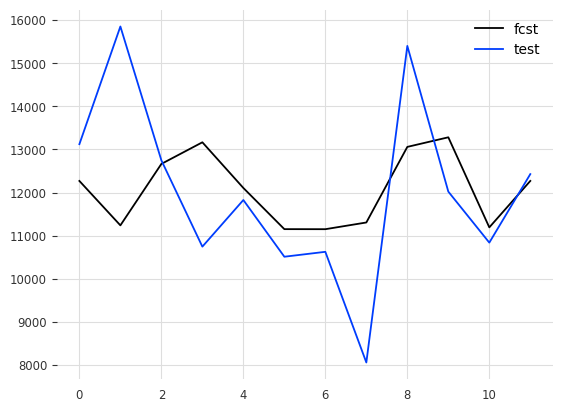

In [12]:
input_chunck_length = 18
n_epochs = 20
num_stacks=15
expansion_coefficient_dim=5

# Specifying a model using the gridsearch parameters
model = NBEATSModel(
    input_chunk_length=input_chunck_length,
    output_chunk_length=12,
    n_epochs=n_epochs,
    num_stacks=num_stacks,
    expansion_coefficient_dim=expansion_coefficient_dim,
    random_state=123
)

# Train the model
model.fit(
    train_series,
    
    # add the promotions as past covariates
    past_covariates=promos_train
)


# Forecast 12 steps using this model
fcst = model.predict(
    n=12,

    # add past covariates (promos train)
    past_covariates=promos_train,
    
).values()

# Compute metric
metric = 1 - mean_absolute_percentage_error(list(test['SALES']), fcst)
print(metric)

# Plot the best forecast
plt.plot(fcst)
plt.plot(list(test['SALES']))
plt.legend(['fcst', 'test'])
